
# Tuberculosis Project
## Primary researchers: Awanti Sambarey, Sriram Chandrasekaran
### Python notebook author: Kirk Smith


In [ ]:
from datetime import date

today = date.today()
print("Last updated on", today)

Last updated on 2023-12-05


In [ ]:
from platform import python_version
python_version()

'3.10.12'

In [ ]:
# install SHAP package
!pip install shap==0.37.0

!pip install matplotlib==3.4.3
!pip install import-ipynb
!pip install dill


In [ ]:
# mount Google Drive in order to import data, scripts, etc.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.insert(0,r"/content/drive/MyDrive/ColabNotebooks/TB")
sys.path.insert(0,r"/content/drive/MyDrive/ColabNotebooks/TB/code")


Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
import os
import openpyxl
from collections import Counter

import missingno
import scipy
from scipy import stats
from sklearn.metrics import matthews_corrcoef
from importlib import reload
import import_ipynb
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from IPython.display import HTML, display
import dill
import pickle

# !wget https://github.com/matomo-org/travis-scripts/blob/master/fonts/Arial.ttf

print(matplotlib.__version__)
np.random.seed(123)

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

3.4.3


In [ ]:
os.chdir("/content/drive/MyDrive/ColabNotebooks/TB")

dill.load_session('./final_TB_workspace_Sept2023.pkl')

fig_path = './Sept23_figures'

In [ ]:
le = LabelEncoder()
imputer = KNNImputer(n_neighbors=3)


In [ ]:
# auto-reload modules
%load_ext autoreload
%autoreload 2

In [ ]:
  %reload_ext autoreload

In [ ]:
# import import_ipynb
# import my_functions2
from my_functions import train_model, make_confusion_matrix


In [ ]:
dill.load_session('./final_TB_workspace_Sept2023.pkl')
# dill.load_session('./final_TB_workspace_May2023.pkl')


### Import data and categorical mapping files

In [ ]:
# import data

# social
df_social = pd.read_excel(r"./tb_data/sampledata_kirk_updated_220408.xlsx",
                     sheet_name=0,engine='openpyxl')
mapping_social = pd.read_excel(r"./tb_data/sampledata_kirk_updated_220408.xlsx",
                        sheet_name=1,engine='openpyxl')

# xray
df_xray = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/xray_Features_all.xlsx",engine='openpyxl')

# pathogen
df_path0 = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/path_feats_levels.xlsx", sheet_name=0, engine='openpyxl')
mapping_path = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/path_feats_levels.xlsx", sheet_name=1,engine='openpyxl')

# ct scan
df_ct = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/TB/tb_data/CT_input.xlsx",engine='openpyxl')



### Define features of each dataset

In [ ]:
# social
non_feats_social = ['patient_id', 'identifier','registration_date','outcome', 'treatment_span', 'patient_id_xray']
features_social = [ele for ele in df_social.columns if ele not in non_feats_social]
numFeats_social = df_social[features_social].select_dtypes(include = [np.number]).columns
objList_social = df_social[features_social].select_dtypes(include = "object").columns

# remove pathogen-related features
feats_to_pathogen = ["drug_regimen", "type_of_resistance", "Indigo_score"]
features_social = [ele for ele in features_social if ele not in feats_to_pathogen]

#  pathogen
df_path = df_path0.merge(df_social[['patient_id','Indigo_score', 'drug_regimen']], on='patient_id', how='inner')
non_feats_path = ['patient_id', 'condition_id','outcome']
features_path = [ele for ele in df_path.columns if ele not in non_feats_path]
numFeats = df_path[features_path].select_dtypes(include = [np.number]).columns
objList_path = df_path[features_path].select_dtypes(include = "object").columns

# xray
non_feats_xray = ['patient_id','outcome','type_of_resistance','Unnamed: 127','Unnamed: 128']
features_xray = [ele for ele in df_xray.columns if ele not in non_feats_xray]
xray_numFeats = df_xray[features_xray].select_dtypes(include = [np.number]).columns
objList_xray = df_xray[features_xray].select_dtypes(include = "object").columns

# ct
non_feats_ct = ['condition_id','patient_id','result_id', 'imagingstudy_id','imaging_date','outcome', 'type_of_resistance']
features_ct = [ele for ele in df_ct.columns if ele not in non_feats_ct]
objList_ct = df_ct[features_ct].select_dtypes(include = "object").columns

df_feat_counts = pd.DataFrame({'Dataset':['Social','Pathogen','X-ray','CT scan', 'All'],
                               'No.Features': [len(features_social), len(features_path), len(features_xray), len(features_ct),
                                               np.sum([len(features_social), len(features_path), len(features_xray), len(features_ct)])]})


In [ ]:
### Load external validation dataset
df_social_ext = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/external_validation_social.xlsx", engine='openpyxl')

# df_xray_ext = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/externalvalidation_cxr.xlsx", engine='openpyxl')
df_xray_ext = pd.read_csv(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/externalvalidation_cxr_may2023.csv")

df_path_ext0 = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/pathogen_external_validation.xlsx", engine='openpyxl')
df_path_ext0.rename(columns={"Mtb family": "Mtbfamily", "Mtb lineage": "Mtblineage"},inplace=True)
df_path_ext = df_path_ext0.merge(df_social_ext[['patient_id','Indigo_score', 'drug_regimen']], on='patient_id', how='inner')

tb_portal_2022 = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/TB portals 2022 data.xlsx", engine='openpyxl')

# generate CT external dataset by using non-training group from TB portal
df1 = tb_portal_2022[['patient_id','outcome','type_of_resistance']+features_ct]
# replace missing with NaN
df2 = df1.replace(['Not Reported'], np.nan)
outer = df2.merge(df_ct['patient_id'], how='outer', on='patient_id', indicator=True)
df_ct_ext = outer[(outer._merge=='left_only')].drop('_merge', axis=1)

print(df_social_ext.shape)
print(df_xray_ext.shape)
print(df_path_ext.shape)
print(df_ct_ext.shape)

Unknown extension is not supported and will be removed


(491, 19)
(373, 130)
(491, 38)
(7540, 23)


In [ ]:
df_image_ids = pd.read_csv(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/mapped_xray_patientids.csv")
df_image_ids.columns

Index(['Xray_patient_id', 'condition_id', 'patient_id', 'type_of_resistance'], dtype='object')

In [ ]:
# fix x-ray ext IDs
df_xray_ext = df_xray_ext.rename(columns={"patient_id": "Xray_patient_id"})
df_image_ids.columns # Xray_patient_id, condition_id, patient_id


df_xray_ext_id = df_xray_ext.merge(df_image_ids[['Xray_patient_id','patient_id']],
                                    left_on='Xray_patient_id', right_on='Xray_patient_id', how='inner')


In [ ]:
# fix CT outcome levels
print(Counter(df_ct_ext.outcome))
df_ct_ext['outcome'] = df_ct_ext['outcome'].replace(['Cured', 'Completed'], 'Success')
df_ct_ext['outcome'] = df_ct_ext['outcome'].replace('Died', 'Failure')
df_ct_ext['outcome'] = df_ct_ext['outcome'].replace(['Lost to follow up', 'Unknown', 'Still on treatment', 'Palliative Care'], np.nan)
Counter(df_ct_ext.outcome)


Counter({'Cured': 3808, 'Died': 827, 'Completed': 821, 'Lost to follow up': 699, 'Failure': 578, 'Still on treatment': 503, 'Palliative Care': 154, 'Unknown': 150})


Counter({'Success': 4629, nan: 1506, 'Failure': 1405})

In [ ]:
def intersection(lst1, lst2):
  lst1 = list(lst1)
  lst2 = list(lst2)
  lst3 = [value for value in lst1 if value in lst2]
  return lst3

def not_intersection(lst1, lst2):
  lst1 = list(lst1)
  lst2 = list(lst2)
  lst3 = [value for value in lst1 if value not in lst2]
  return lst3

### Create function to encode the categorical features
If the feature is found in the uploaded encoding map, use the map (in case the use wants to control the mapping, such as for ordinal groups). Otherwise, use Scikit Learn's Label Encoder.

In [ ]:
#Label Encoding for object to numeric conversion
# the number of missing data will typically be more after mapping, due to groups like "Unknown" being assigned to NaN

def categorical_encoding(data, categ_vars, mapping=None):
  df = data.copy()
  my_dictionary_df = pd.DataFrame()

  for feat in categ_vars:
      print("\n")
      print(feat)
      sr = df[feat]
      mask = sr.isnull()
      print("Num missing before: ",pd.isnull(sr).sum())

      if not isinstance(mapping, type(None)) and feat in mapping.columns:
      # if feat in mapping.columns:
        print("MANUAL MAPPING!")
        # subset mapping spreadsheet
        ints = mapping.columns.get_loc(feat)+1
        col = mapping.columns.get_loc(feat)
        df_map_temp = mapping.iloc[:,col:col+2]
        df_map_temp = df_map_temp[df_map_temp.iloc[:,0].notna()]
        df_map_temp.columns = ["feature","integer"]

        # create pandas series and find values not in encoding map
        sr = df[feat].astype(str)
        val_uniq = np.unique(sr)
        not_in_list = [value for value in val_uniq if value not in list(df_map_temp.feature)]
        print("Unique feature values NOT found in encoding map: ",not_in_list)

        # first encode values that are in map, then replace those not in map with NaN
        sr.replace(to_replace = list(df_map_temp['feature']), value = list(df_map_temp['integer']), inplace=True, regex=False)
        if len(not_in_list)>0:
          print("Replacing non-mapped values with NaN...")
          sr.replace(to_replace = not_in_list, value = np.nan, inplace=True, regex=False)

        # update dataframe column and store mapping
        le_name_mapping = {"feature" : feat,
                          "categories" : df_map_temp.iloc[:,0],
                          "classes" : df_map_temp.iloc[:,1]}

      else:
          print("AUTO MAPPING!")
          sr.replace(to_replace= "NaN", value = np.nan, inplace=True, regex=False)
          sr = le.fit_transform(sr.astype(str))

          # keep track of category-to-integer mapping
          le_name_mapping = {"feature":feat,
                            "categories":le.classes_,
                            "classes":le.transform(le.classes_)}

      sr = pd.Series(sr).where(~mask, df[feat])
      df[feat] = sr
      print("Num missing after: ", pd.isnull(df[feat]).sum())

      df_map = pd.DataFrame.from_dict(le_name_mapping).sort_values(by='classes')
      my_dictionary_df = pd.concat([my_dictionary_df, df_map])

  return df, my_dictionary_df

  # my_dictionary_df.to_csv("./tb_categorical_encoding_map_val.csv",index=False)

### Run mapping

In [ ]:
 %%capture
# social
[df_social_encoded, my_dictionary_social] = categorical_encoding(data=df_social,
                                                               categ_vars=objList_social,
                                                               mapping=mapping_social)
# pathogen
[df_pathogen_encoded, my_dictionary_pathogen] = categorical_encoding(data=df_path,
                                                                   categ_vars=objList_path,
                                                                   mapping=mapping_path)
# xray
[df_xray_encoded, my_dictionary_xray] = categorical_encoding(data=df_xray,
                                                       categ_vars=objList_xray,
                                                       mapping=None)
# ct
[df_ct_encoded, my_dictionary_ct] = categorical_encoding(data=df_ct,
                                                       categ_vars=objList_ct,
                                                       mapping=None)



In [ ]:
%%capture
### repeat for validation datasets ###
[df_social_validate, my_dictionary_social2] = categorical_encoding(data=df_social_ext,
                                                               categ_vars=objList_social,
                                                               mapping=mapping_social)
# pathogen
[df_pathogen_validate, my_dictionary_pathogen2] = categorical_encoding(data=df_path_ext,
                                                                   categ_vars=objList_path,
                                                                   mapping=mapping_path)
# xray
[df_xray_validate, my_dictionary_xray2] = categorical_encoding(data=df_xray_ext_id,
                                                       categ_vars=objList_xray,
                                                       mapping=None)
# ct
[df_ct_validate, my_dictionary_ct2] = categorical_encoding(data=df_ct_ext,
                                                       categ_vars=objList_ct,
                                                       mapping=None)



## Main text figures

### Figure 2 - Social features

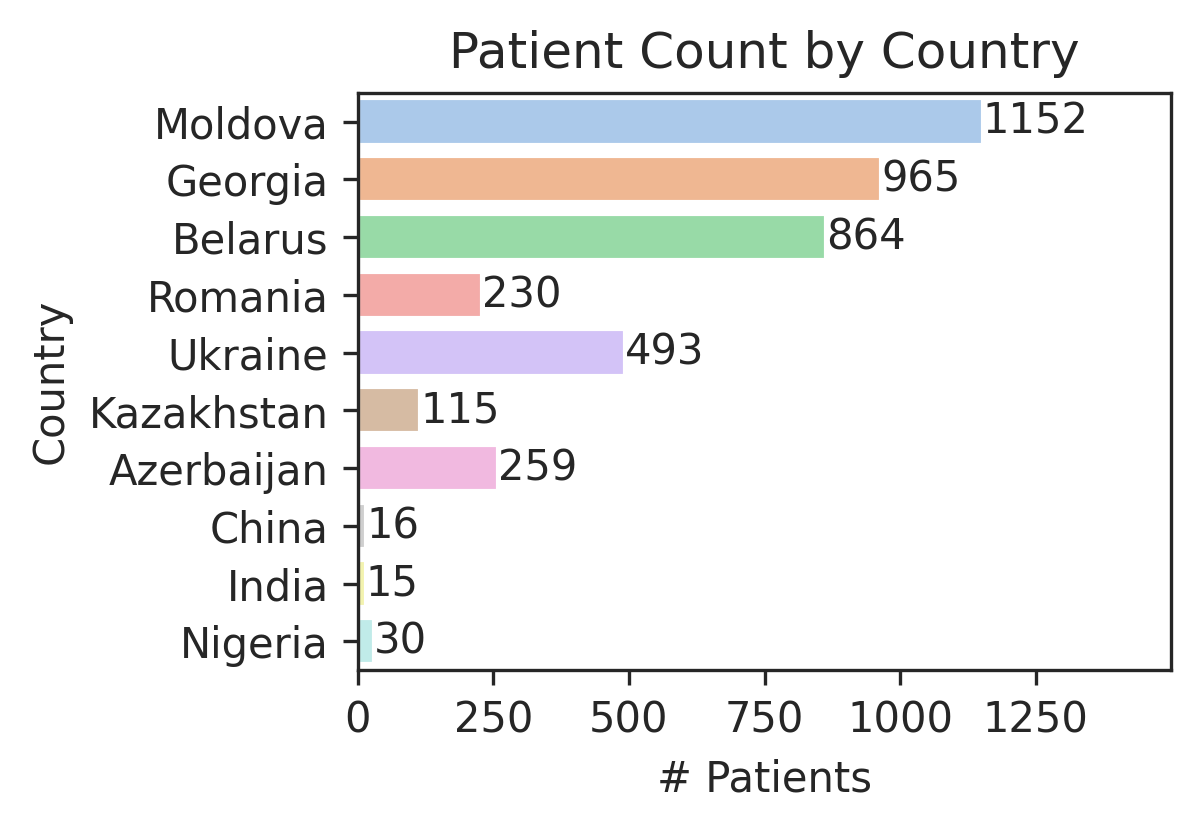

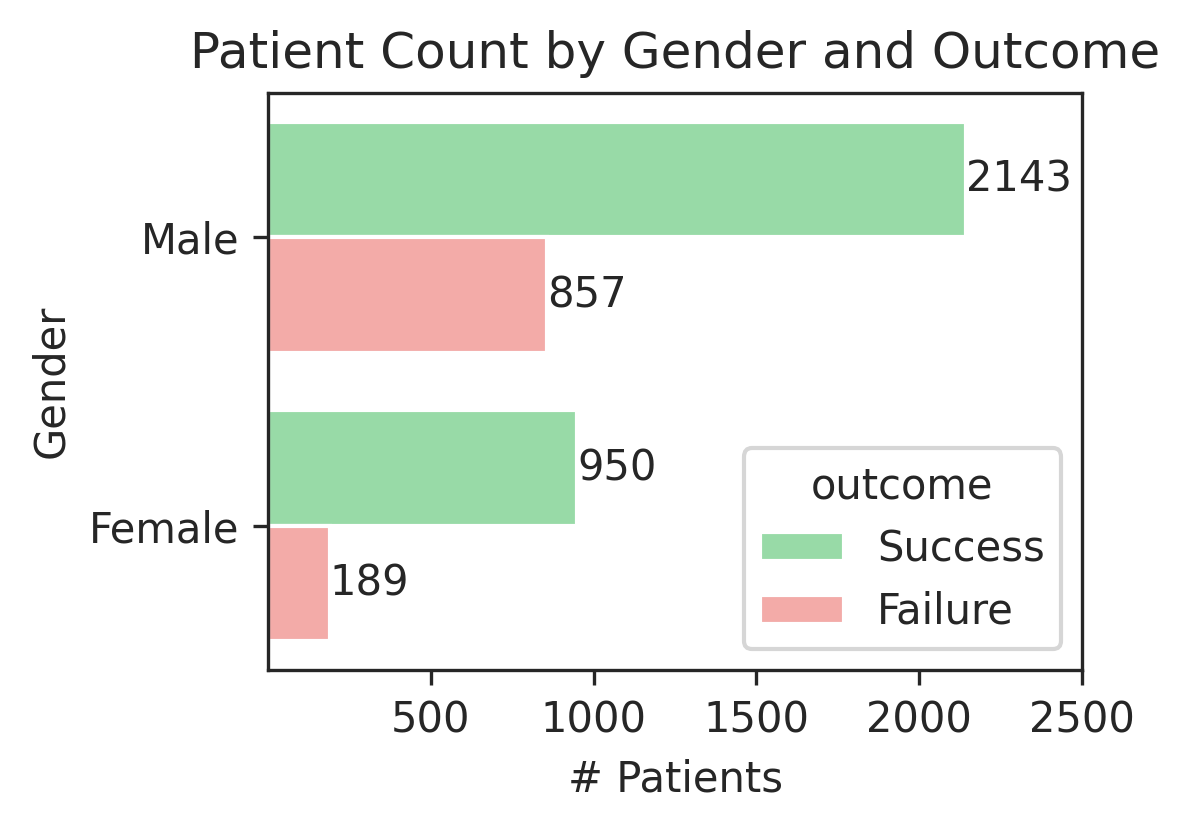

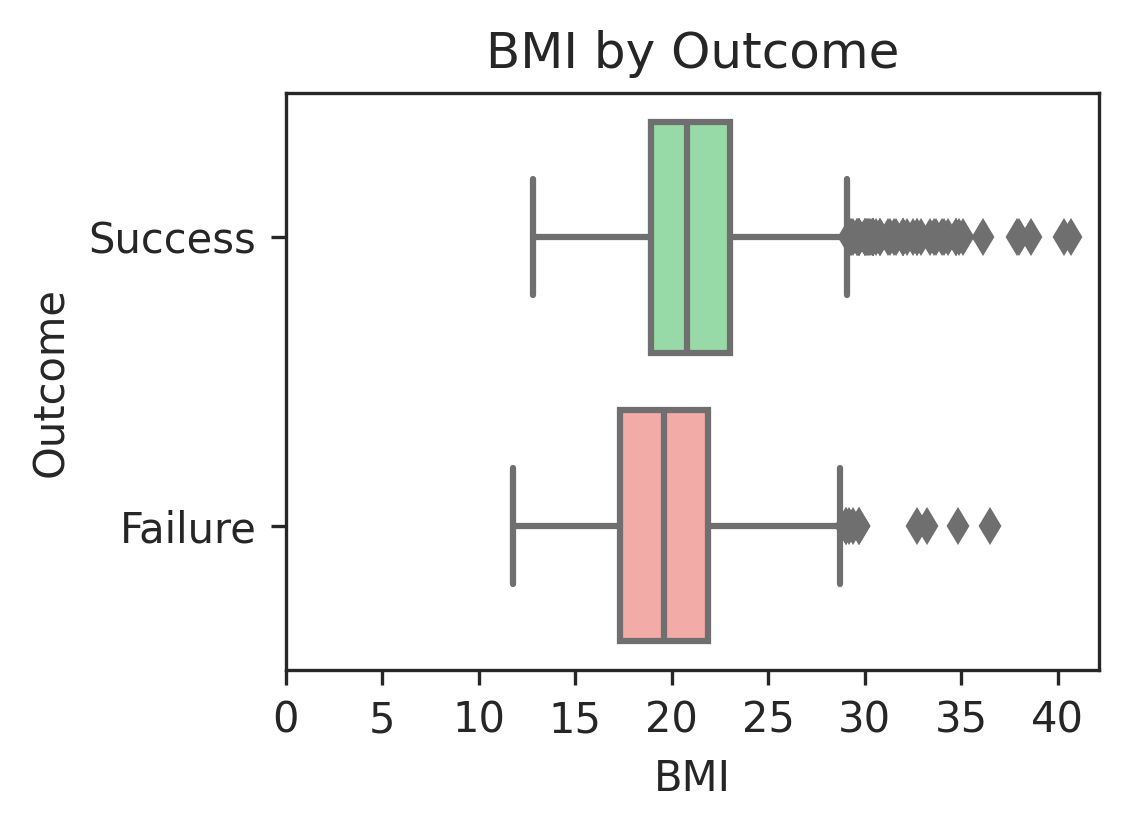

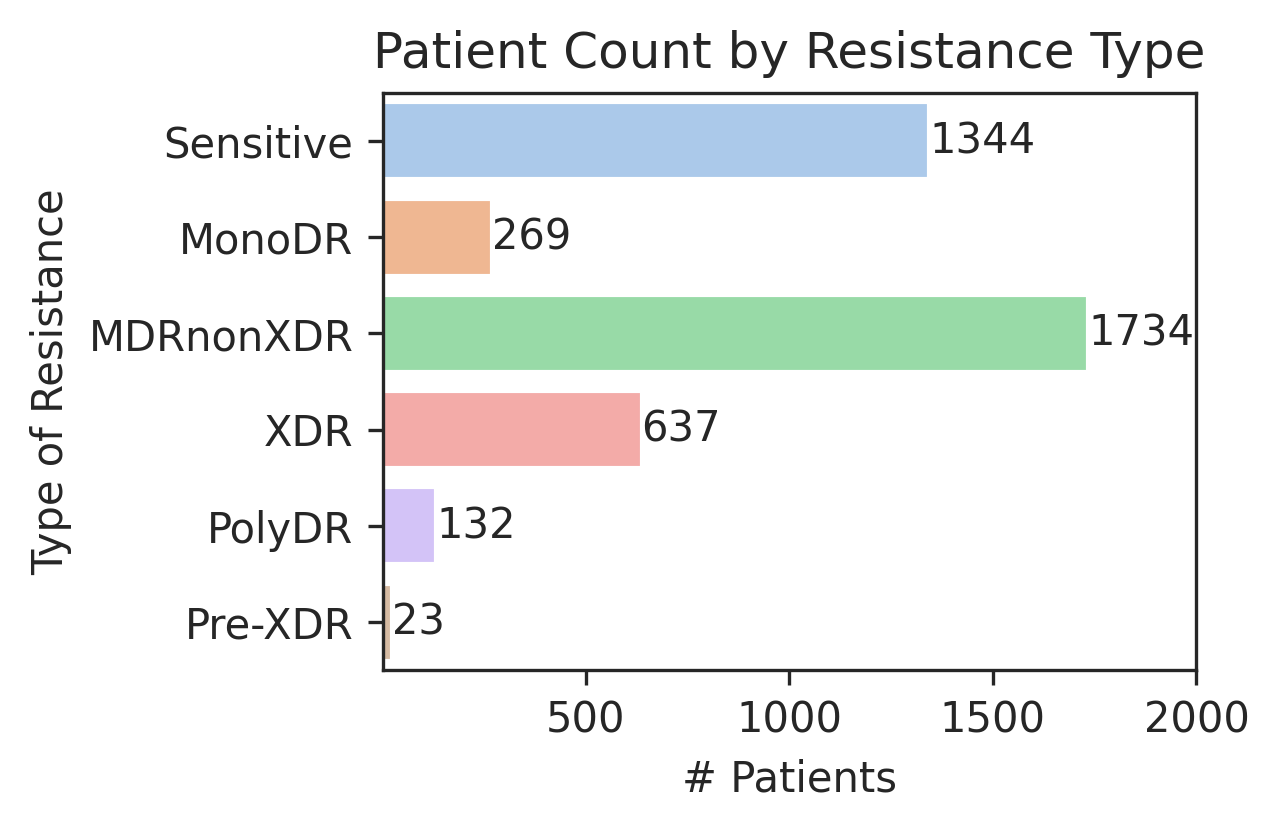

In [ ]:
fig_path = "final_code_figures"
# Check whether the specified path exists or not
isExist = os.path.exists(fig_path)
if not isExist:
   os.makedirs(fig_path)
   print("The new directory is created!")

sns.set_style("white")
sns.set_style("ticks")

# Figure 2A - # samples by country
plt.figure(figsize=(3.5,2.5))
ax=sns.countplot(y=df_social["country"], palette="pastel")
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_xlim(1, 1500)
# plt.xticks()
plt.ylabel("Country")
plt.xlabel("# Patients")
plt.xticks(np.arange(0, 1500, 250))

plt.title("Patient Count by Country", fontsize=12)
plt.savefig(fig_path+"/Fig2_country_counts_2312.pdf",
            bbox_inches="tight",
            format="pdf",
            dpi=600)
plt.show()

# Figure 2B - # samples by gender, grouped by outcome
plt.figure(figsize=(3.5, 2.5))
ax=sns.countplot(data=df_social, y="gender", hue="outcome", palette=['#8de5a1',"#ff9f9b"])
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlim(1, 2500)
# plt.xticks(rotation=45)
plt.ylabel("Gender")
plt.xlabel("# Patients")
plt.title("Patient Count by Gender and Outcome", fontsize=12)
plt.savefig(fig_path+"/Fig2_gender_counts_2312.pdf",
            bbox_inches="tight",
            format="pdf",
            dpi=600)
plt.show()

# Figure 2C - BMI, grouped by outcome
plt.figure(figsize=(3.5, 2.5))
sns.boxplot(data=df_social, y="outcome", x="bmi", palette=['#8de5a1',"#ff9f9b"])
# plt.xticks(rotation=45)
plt.ylabel("Outcome")
plt.xlabel("BMI")
plt.title("BMI by Outcome", fontsize=12)
plt.xticks(np.arange(0, round(max(df_social.bmi) * 5) / 5, 5))

plt.savefig(fig_path+"/Fig2_BMI_vs_outcome_2312.pdf",
            bbox_inches="tight",
            format="pdf",
            dpi=600)
plt.show()

# Figure 2D - type of resistance
plt.figure(figsize=(3.5, 2.5))
ax=sns.countplot(data=df_social, y="type_of_resistance", palette="pastel")
plt.title("Patient Count by Resistance Type", fontsize=12)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_xlim(1, 2000)
# plt.xticks(rotation=45)
plt.ylabel("Type of Resistance")
plt.xlabel("# Patients")
plt.savefig(fig_path+"/Fig2_resistance_counts_2312.pdf",
            bbox_inches="tight",
            format="pdf",
            dpi=600)
plt.show()

### Figure 5 - Pathogen features

In [ ]:
# Fig 5A - type of resistance by Mtb family
df_tmp = df_path.loc[df_path['Mtbfamily'].isin(['T1','T2','T3','S', 'H1', 'H3', 'T5-RUS1', 'LAM9', 'Beijing'])]

plt.figure(figsize=(3,2))  #(5,4)
sns.countplot(data=df_tmp, x="type_of_resistance", hue="Mtbfamily", dodge=False)
plt.xticks(rotation=45)
plt.xlabel("Type of Resistance")
plt.ylabel("# Patients")
plt.savefig(fig_path+"/Fig5_resistance_by_Mtbfamily.png",
            bbox_inches="tight",
            format="png",
            dpi=600)
plt.show()

# Fig 5B - mutations associated with failure
df_geneMut_failure_pvals = pd.DataFrame({"Gene":['gyrA','rpsL','katG','rpoB','inhA','rrs'],
                                         "pvalue": [6.77E-17,2.99E-10,1.83E-09,6.12E-08,7.23E-07,3.95E-04]})
df_geneMut_failure_pvals["-log10pval"] = np.log10(df_geneMut_failure_pvals.pvalue)*-1
df_geneMut_failure_pvals.head()

# plot pval
plt.figure(figsize=(3,2))
sns.barplot(x="Gene", y="-log10pval", data=df_geneMut_failure_pvals, color="#ffb482")
plt.savefig(fig_path+"/Fig5_geneMut_failure_pvals.png",
            bbox_inches="tight",
            format="png",
            dpi=600)
plt.show()

# Fig 5C - drug resistance associated with failure

dr_failure_pvals = pd.read_csv(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/drugResist_failure_pvals.csv")
dr_failure_pvals["-log10pval"] = np.log10(dr_failure_pvals.Pvalue)*-1

# plot pval
plt.figure(figsize=(3,2))
sns.barplot(x="Drug", y="-log10pval", data=dr_failure_pvals, color="#ffb482")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.savefig(fig_path+"/Fig5_drugResist_failure_pvals.png",
            bbox_inches="tight",
            format="png",
            dpi=600)
plt.show()

### Figure 7 Associations between features from all TB datasets

In [ ]:
data_all = pd.read_excel(r"/content/drive/MyDrive/ColabNotebooks/TB/tb_data/mergedfile_topfeatures_2023.xlsx",sheet_name=0,engine='openpyxl')
top_features = data_all.columns[1:].tolist()
top_features.remove('outcome')

# convert int cols to float
int_cols = data_all.select_dtypes(include=['int']).columns
data_all[int_cols] = data_all[int_cols].astype(float)


## Test for associations between the features

### Create function to loop through features and apply the appropriate test
1.   Float vs Float, use Kendall rank correlation (non-parametric version of Pearson's)
2.   Float vs Object, use Kruskal Wallis test (non-parametric version of ANOVA)
3.   Object vs Object, use Chi Square test

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# now get associations for all features
def get_associations(data, features):
  df_pvals = pd.DataFrame()
  for cur_feat in features:
    print(cur_feat)
    cur_type = data[cur_feat].dtype
    cur_pvals = []
    for feat in features:
      if feat==cur_feat:
        my_pval=0
      else:
        df_nonan = data[[feat, cur_feat]].dropna()
        # print("main feat: {}, temp_feat: {}".format(cur_feat, feat))
        my_dtypes = df_nonan[[cur_feat, feat]].dtypes
        if (my_dtypes[0]=="float64") & (my_dtypes[1]=="float64"):
          # print("{}: Kendall test!".format(feat))
          my_stat, my_pval = stats.kendalltau(df_nonan[cur_feat], df_nonan[feat])
        elif len(np.unique(df_nonan[feat].astype('str')))<2:
            print("Not enough values for test!")
            my_pval=np.nan
        elif (my_dtypes[0]=="float64") & (my_dtypes[1]=="object"):
          # print("{}: KW test!".format(feat))
          values_per_group = [col for col_name, col in df_nonan.groupby(feat)[cur_feat]]
          my_stat, my_pval = stats.kruskal(*values_per_group)
        elif (my_dtypes[1]=="float64") & (my_dtypes[0]=="object"):
          # print("{}: KW test!".format(feat))
          values_per_group = [col for col_name, col in df_nonan.groupby(cur_feat)[feat]]
          my_stat, my_pval = stats.kruskal(*values_per_group)
        elif (my_dtypes[0]=="object") & (my_dtypes[1]=="object"):
          # print("{}: Chi Square test!".format(feat))
          contigency= pd.crosstab(df_nonan[cur_feat], df_nonan[feat])
          my_pval = stats.chi2_contingency(contigency)[1]
        else:
          print("Check data types!")
          break
      cur_pvals.append(my_pval)
    df_pvals[cur_feat] = cur_pvals
  return(df_pvals)


In [ ]:
%%capture
# use function to get feature assoications
dv_pvals_all = get_associations(data_all, top_features)

# # save to file
dv_pvals_all.index = top_features
dv_pvals_all.to_csv("feature_association_pvals_may2023.csv")

### Generate association heatmaps

In [ ]:
### Generate heatmaps of the resulting p-values
# 1.   No p-value correction (*showing -log10 p-values)

df_pvals_log = np.log10(dv_pvals_all)*-1

tick_labels = df_pvals_log.index

df_pvals_log.replace([np.inf, -np.inf], 0, inplace=True)

# # Create a mask
mask = np.triu(np.ones_like(df_pvals_log, dtype=bool))

# Create a custom divergin palette
sns.set(style='white')
cmap = sns.light_palette("darkred", as_cmap=True, reverse=False)

# plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(figsize=(12,12)) # (12,12)
ax=sns.heatmap(df_pvals_log, mask=mask, cmap=cmap,vmin=0, vmax=20)
# ax.set_xticks(features)
ax.set_xticklabels(tick_labels, rotation = 90, size=8)
ax.set_yticklabels(tick_labels, rotation = 0,  size=8)
plt.savefig(fig_path+"/association_heatmap.pdf",bbox_inches ="tight", dpi=600, format="pdf")
plt.show()

In [ ]:
# 2. repeat with Bonferroni correction

n_tests = (len(all_features)**2)/2-len(all_features)

df_pvals_bonf = dv_pvals_all*n_tests

# heatmap for all_feats_merged
df_pvals_log_bonf = np.log10(df_pvals_bonf)*-1
tick_labels = df_pvals_log.index
df_pvals_log_bonf.replace([np.inf, -np.inf], 0, inplace=True)
df_pvals_log_bonf.to_csv("feature_association_pvals_bonf_corrected.csv")

# # Create a mask
mask = np.triu(np.ones_like(df_pvals_log_bonf, dtype=bool))

# Create a custom divergin palette
cmap = sns.light_palette("darkred", as_cmap=True, reverse=False)

# plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(figsize=(12,12))
ax=sns.heatmap(df_pvals_log_bonf, mask=mask, cmap=cmap,vmin=0, vmax=20)
ax.set_xticklabels(tick_labels, rotation = 90, size=8)
ax.set_yticklabels(tick_labels, rotation = 0,  size=8)
plt.savefig(fig_path+"/association_heatmap_final_bonferroni.pdf",dpi=600, format="pdf", bbox_inches ="tight")
plt.show()


## Data exploration - missing data

In [ ]:
# training datasets
# help(missingno.bar)

# Social
ax=missingno.bar(df_social_encoded[features_social],
             color="dodgerblue", sort="descending", figsize=(3,1), fontsize=4)
ax.set_title('No. data for Social Features',
             fontsize = 8)
plt.show()

# Pathogen
ax=missingno.bar(df_pathogen_encoded[features_path],
             color="dodgerblue", sort="descending", figsize=(3,1), fontsize=4)
ax.set_title('No. data for Pathogen Features',
             fontsize = 8)
plt.show()

# CT
ax=missingno.bar(df_ct_encoded[features_ct],
             color="dodgerblue", sort="descending", figsize=(3,1), fontsize=4)
ax.set_title('No. data for CT Features',
             fontsize = 8)
plt.show()

# Xray - no missing data

## Data prep

### Remove duplicate patients

In [ ]:
df_social_uniq = df_social_encoded.drop_duplicates() #(subset=['patient_id']
df_pathogen_uniq = df_pathogen_encoded.drop_duplicates()
df_ct_uniq = df_ct_encoded.drop_duplicates()
df_xray_uniq = df_xray_encoded.drop_duplicates()

print("Social dataset dropped {} duplicate rows...".format(df_social_encoded.shape[0]-df_social_uniq.shape[0]))
print("Pathogen dataset dropped {} duplicate rows...".format(df_pathogen_encoded.shape[0]-df_pathogen_uniq.shape[0]))
print("CT dataset dropped {} duplicate rows...".format(df_ct_encoded.shape[0]-df_ct_uniq.shape[0]))
print("Xray dataset dropped {} duplicate rows...".format(df_xray_encoded.shape[0]-df_xray_uniq.shape[0]))

### Remove features with >90% missing

In [ ]:
# remove features with too many missing values
threshold = 0.9
# social
highMissing_feats_social = df_social_uniq.columns[df_social_uniq.isnull().mean() > threshold]
print(highMissing_feats_social)
features_social_lowMiss = [ele for ele in features_social if ele not in highMissing_feats_social]
print("From {} to {} social features...".format(len(features_social), len(features_social_lowMiss)))

# ct
highMissing_feats_ct = df_ct_uniq.columns[df_ct_uniq.isnull().mean() > threshold]
print(highMissing_feats_ct)
features_ct_lowMiss = [ele for ele in features_ct if ele not in highMissing_feats_ct]
print("From {} to {} CT features...".format(len(features_ct), len(features_ct_lowMiss)))

# pathogen
highMissing_feats_pathogen = df_pathogen_uniq.columns[df_pathogen_uniq.isnull().mean() > threshold]
print(highMissing_feats_pathogen)
features_pathogen_lowMiss = [ele for ele in features_path if ele not in highMissing_feats_pathogen]
print("From {} to {} pathogen features...".format(len(features_path), len(features_pathogen_lowMiss)))

# xray (no missing)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Remove features that are 100% or more similar

def remove_lowVar(df, minVariance):
  selector = VarianceThreshold(threshold = minVariance)
  selector.fit(df)
  df_new = df.loc[:, selector.get_support()]
  print("Removed {} of {} features for having zero variance".format(df.shape[1]- df_new.shape[1], df.shape[1]))
  return(df_new.columns)

print("Social...")
features_social_highVar = remove_lowVar(df_social_uniq[features_social_lowMiss], 0)

print("Pathogen...")
features_pathogen_highVar = remove_lowVar(df_pathogen_uniq[features_pathogen_lowMiss], 0)

print("CT...")
features_ct_highVar = remove_lowVar(df_ct_uniq[features_ct_lowMiss], 0)

print("Xray...")
features_xray_highVar = remove_lowVar(df_xray_uniq[features_xray], 0)


### Remove patients with too much missing data

In [ ]:
threshold = 0.4  # remove patients with more than 40% missing

# Pathogen
rows_lowMiss = (df_social_uniq[features_social_highVar].isnull().sum(axis = 1) / len(features_social_highVar)) <= threshold
df_social_lowMiss = df_social_uniq[rows_lowMiss].reset_index()
print("Social dataset: {} to {} patients...".format(df_social_uniq.shape[0], df_social_lowMiss.shape[0]))

# Pathogen
rows_lowMiss = (df_pathogen_uniq[features_pathogen_highVar].isnull().sum(axis = 1) / len(features_pathogen_highVar)) <= threshold
df_pathogen_lowMiss = df_pathogen_uniq[rows_lowMiss].reset_index()
print("Pathogen dataset: {} to {} patients...".format(df_pathogen_uniq.shape[0], df_pathogen_lowMiss.shape[0]))

# CT
rows_lowMiss = (df_ct_uniq[features_ct_highVar].isnull().sum(axis = 1) / len(features_ct_highVar)) <= threshold
df_ct_lowMiss = df_ct_uniq[rows_lowMiss].reset_index()
print("CT dataset: {} to {} patients...".format(df_ct_uniq.shape[0], df_ct_lowMiss.shape[0]))

# xray
rows_lowMiss = (df_xray_uniq[features_xray_highVar].isnull().sum(axis = 1) / len(features_xray_highVar)) <= threshold
df_xray_lowMiss = df_xray_uniq[rows_lowMiss].reset_index()
print("Xray dataset: {} to {} patients...".format(df_xray_uniq.shape[0], df_xray_lowMiss.shape[0]))

In [ ]:
# what does missing data look like at this point...
df_combined_tmp = df_xray_lowMiss[list(features_xray_highVar)+['patient_id','outcome']]

df_combined_tmp = df_combined_tmp.merge(df_ct_lowMiss[list(features_ct_highVar)+['patient_id','outcome']],
                                  on='patient_id', how='outer')
# fix outcome
df_combined_tmp['outcome'] = df_combined_tmp['outcome_x'].fillna(df_combined_tmp['outcome_y'])

df_combined_tmp = df_combined_tmp.merge(df_pathogen_lowMiss[list(features_pathogen_highVar)+['patient_id']],
                                        on='patient_id', how='outer')
df_combined_tmp = df_combined_tmp.merge(df_social_lowMiss[list(features_social_highVar)+['patient_id']],
                                  on='patient_id', how='outer')



In [ ]:
fig , ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_combined_tmp.isna().transpose(),
            cmap="coolwarm",
            cbar_kws={'label': 'Missing Data'},ax=ax)
plt.show()-

### Impute remaining missing values

In [ ]:
imputer = KNNImputer(n_neighbors=2)

# Social
df_social_imputed = pd.DataFrame(imputer.fit_transform(df_social_lowMiss[features_social_highVar]),columns=features_social_highVar)
df_social_imputed['patient_id'] = df_social_lowMiss['patient_id']
df_social_imputed['outcome'] = df_social_lowMiss['outcome']
print("Social dataset: from {} to {} missing values...".format(df_social_lowMiss[features_social_highVar].isnull().sum().sum(),
                                                               df_social_imputed[features_social_highVar].isnull().sum().sum()))
# Pathogen
df_pathogen_imputed = pd.DataFrame(imputer.fit_transform(df_pathogen_lowMiss[features_pathogen_highVar]),columns=features_pathogen_highVar)
df_pathogen_imputed['patient_id'] = df_pathogen_lowMiss['patient_id']
df_pathogen_imputed['outcome'] = df_pathogen_lowMiss['outcome']
print("Pathogen dataset: from {} to {} missing values...".format(df_pathogen_lowMiss[features_pathogen_highVar].isnull().sum().sum(),
                                                               df_pathogen_imputed[features_pathogen_highVar].isnull().sum().sum()))

# CT
df_ct_imputed = pd.DataFrame(imputer.fit_transform(df_ct_lowMiss[features_ct_highVar]),columns=features_ct_highVar)
df_ct_imputed['patient_id'] = df_ct_lowMiss['patient_id']
df_ct_imputed['outcome'] = df_ct_lowMiss['outcome']
print("CT dataset: from {} to {} missing values...".format(df_ct_lowMiss[features_ct_highVar].isnull().sum().sum(),
                                                               df_ct_imputed[features_ct_highVar].isnull().sum().sum()))


### Combine datasets for integrated model

In [ ]:

features_xray_final = list(features_xray_highVar)
features_ct_final = list(features_ct_highVar)
features_pathogen_final = list(features_pathogen_highVar)
features_social_final = list(features_social_highVar)

all_feats = features_xray_final + features_pathogen_final + features_social_final #features_ct_final
len(all_feats)

# OPTION 1: START WITH XRAY DATASET AND INNER-JOIN ALL --> LESS PATIENTS, BUT NO FURTHER IMPUTATION REQUIRED
df_combined = df_xray_lowMiss[features_xray_final+['patient_id','outcome']]
print(df_combined.shape)

# # add CT
# df_combined = df_combined.merge(df_ct_imputed[features_ct_final+['patient_id','outcome']],
#                                   on='patient_id', how='inner')
# print(df_combined.shape)
# # fix outcome
# df_combined['outcome'] = df_combined['outcome_x'].fillna(df_combined['outcome_y'])

# add pathogen
df_combined = df_combined.merge(df_pathogen_imputed[features_pathogen_final+['patient_id']],
                                    on='patient_id', how='inner')
print(df_combined.shape)

# add social
df_combined = df_combined.merge(df_social_imputed[features_social_final+['patient_id']],
                                  on='patient_id', how='inner')
print(df_combined.shape)
print(Counter(df_combined.outcome))

In [ ]:
# OPTION 2: START WITH PATHOGEN DATASET AND LEFT-JOIN XRAY --> MORE PATIENTS, BUT IMPUTE LARGE AMOUNTS OF XRAY DATA
# add pathogen
df_combined_highN = df_pathogen_imputed[features_pathogen_final+['patient_id','outcome']]
print(df_combined_highN.shape)

# add social
df_combined_highN = df_combined_highN.merge(df_social_imputed[features_social_final+['patient_id']],
                                  on='patient_id', how='inner')


print(df_combined_highN.shape)
print(Counter(df_combined_highN.outcome))

# add xray data
df_combined_highN = df_combined_highN.merge(df_xray_lowMiss[features_xray_final+['patient_id','outcome']],
                                on='patient_id', how='left')
print(df_combined_highN.shape)

df_combined_highN['outcome'] = df_combined_highN['outcome_x'].fillna(df_combined_highN['outcome_y'])
print(Counter(df_combined_highN.outcome))



In [ ]:
all_cols = all_feats + ['patient_id', 'outcome']
df_combined = df_combined[all_cols]
print(df_combined.shape)

df_combined_highN = df_combined_highN[all_cols]
print(df_combined_highN.shape)

In [ ]:
# remove features with >50% many missing values
highMissing_feats_all = df_combined.columns[df_combined.isnull().mean() > 0.50]
all_feats_lowMiss = [ele for ele in all_feats if ele not in highMissing_feats_all]
print("From {} to {} features (missingness)...".format(len(all_feats), len(all_feats_lowMiss)))

print(len(intersection(all_feats_lowMiss, features_social_final)))
print(len(intersection(all_feats_lowMiss, features_pathogen_final)))
print(len(intersection(all_feats_lowMiss, features_xray_final)))
print(len(intersection(all_feats_lowMiss, features_ct_final)))

In [ ]:
# remove features with zero variance
from sklearn.feature_selection import VarianceThreshold

my_threshold = 1
selector = VarianceThreshold(threshold = (1-my_threshold))

selector.fit(df_combined[all_feats_lowMiss])

concol = [column for column in df_combined[all_feats_lowMiss].columns
          if column not in df_combined[all_feats_lowMiss].columns[selector.get_support()]]

df_combined_final = df_combined.drop(concol,axis=1)

all_feats_final = [ele for ele in all_feats_lowMiss if ele not in concol]

a = all_feats_lowMiss
b = all_feats_final
c = {element for element in a if element not in b}
print(c)
print("From {} to {} features (no variance)...".format(len(all_feats_lowMiss), len(all_feats_final)))


In [ ]:

plt.figure(figsize=(10,6))
sns.heatmap(df_combined_highN.isna().transpose(),
            cmap="coolwarm",
            cbar_kws={'label': 'Missing Data'})
plt.show()

In [ ]:
# impute missing data for remaining patients
missing=df_combined_final.isnull().sum().sum()
print("Check for missing: {} ({:.2f}% of dataframe)".format(missing, (missing/df_combined_final.size)*100))

df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_combined_final[all_feats_final]),
                                    columns=all_feats_final)
df_combined_imputed['patient_id'] = df_combined_final.patient_id
print("Check for no missing:",df_combined_imputed.isnull().sum().sum())
df_combined_imputed['outcome'] = df_combined_final.outcome


# ## repeat, but with categorical vars
# all_obj_features = list(objList_path) + list(objList_social) + list(objList_ct) + list(objList_xray)
# all_obj_features_final = np.unique(intersection(all_obj_features, all_feats_final))

# print(len(all_obj_features))
# print(len(all_feats_final))
# print(len(all_obj_features_final))

# df_combined_cat = df_combined_final.copy()

# df_combined_cat[all_obj_features_final] = df_combined_cat[all_obj_features_final].astype('category')


# missing=df_combined_cat.isnull().sum().sum()
# print("Check for missing: {} ({:.2f}% of dataframe)".format(missing, (missing/df_combined_cat.size)*100))

# df_combined_imputed_cat = pd.DataFrame(imputer.fit_transform(df_combined_cat[all_feats_final]),
#                                     columns=all_feats_final)
# df_combined_imputed_cat['patient_id'] = df_combined_cat.patient_id
# print("Check for no missing:",df_combined_imputed_cat.isnull().sum().sum())
# df_combined_imputed_cat['outcome'] = df_combined_final.outcome


In [ ]:
### repeat for highN version

#1.) remove features with >50% many missing values
highMissing_feats_all = df_combined_highN.columns[df_combined_highN.isnull().mean() > 0.99]
all_feats_lowMiss = [ele for ele in all_feats if ele not in highMissing_feats_all]
print("From {} to {} features (missingness)...".format(len(all_feats), len(all_feats_lowMiss)))

print("Social features:", len(intersection(all_feats_lowMiss, features_social_final)))
print("Pathogen features:", len(intersection(all_feats_lowMiss, features_pathogen_final)))
print("Xray features:",len(intersection(all_feats_lowMiss, features_xray_final)))
print("CT features",len(intersection(all_feats_lowMiss, features_ct_final)))

#2.) # remove features with zero variance

my_threshold = 1
selector = VarianceThreshold(threshold = (1-my_threshold))

selector.fit(df_combined_highN[all_feats_lowMiss])

concol = [column for column in df_combined_highN[all_feats_lowMiss].columns
          if column not in df_combined_highN[all_feats_lowMiss].columns[selector.get_support()]]

df_combined_highN_final = df_combined_highN.drop(concol,axis=1)

all_feats_final = [ele for ele in all_feats_lowMiss if ele not in concol]

a = all_feats_lowMiss
b = all_feats_final
c = {element for element in a if element not in b}
print(c)
print("From {} to {} features (no variance)...".format(len(all_feats_lowMiss), len(all_feats_final)))

#3.) # impute missing data for remaining patients
missing=df_combined_highN_final.isnull().sum().sum()
print("Check for missing: {} ({:.2f}% of dataframe)".format(missing, (missing/df_combined_highN_final.size)*100))

df_combined_highN_imputed = pd.DataFrame(imputer.fit_transform(df_combined_highN_final[all_feats_final]),
                                    columns=all_feats_final)
df_combined_highN_imputed['patient_id'] = df_combined_highN_final.patient_id
print("Check for no missing:",df_combined_highN_imputed.isnull().sum().sum())
df_combined_highN_imputed['outcome'] = df_combined_highN_final.outcome

Counter(df_combined_highN_imputed['outcome'])

## Machine-learning


### Test various ML algorithms

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
import xgboost
from sklearn import model_selection
from sklearn import preprocessing
import scipy.stats as st


In [ ]:
def testAlgorgithms(X, y, condition, path, scoring='f1_macro'):
  pltFont = {'fontname':'Arial'}
  models = []
  models.append(('LR', LogisticRegression(max_iter=5000, penalty=None)))
  models.append(('Ridge', LogisticRegressionCV(max_iter=5000, penalty='l2')))
  # models.append(('XGB', xgboost.XGBClassifier(n_estimators=100,max_depth=6,
  #                                             # use_label_encoder=False,
  #                                             eval_metric='mlogloss')))
  models.append(('KNN', KNeighborsClassifier()))
  models.append(('DT', DecisionTreeClassifier()))
  models.append(('AB', AdaBoostClassifier(n_estimators=100)))
  models.append(('RF', RandomForestClassifier(n_estimators=100,max_depth=10)))
  models.append(('SVM', SVC()))

  results = []
  names = []
  seed = 123

  scaler = preprocessing.StandardScaler()
  X_scaled = scaler.fit_transform(X)

  for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_scaled, y,
                                                cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    # print(msg)

  df = pd.DataFrame(results).T
  df.columns = names
  loop_stats = df.describe()
  print(loop_stats)

  CIs = st.t.interval(confidence=0.95, df=len(df)-1,
            loc=np.mean(df), scale=st.sem(df))


  # plot CV scores
  plt.rcParams.update(plt.rcParamsDefault)
  plt.rcParams['xtick.major.pad']='10'
  fig, ax = plt.subplots(figsize=(8,6))
  # ax.set_facecolor('0.9')
  bg=ax.bar(names, np.mean(df),
          yerr=loop_stats.loc['std',:],
          align='center',
          alpha=0.5,
          ecolor='black',
          capsize=10,
          width=0.8)
  ax.set_ylim([0, 1.0])
  plt.yticks(**pltFont)
  ax.set_xticklabels(names,**pltFont)
  ax.tick_params(axis='both', which='major', labelsize=20)
  ax.set_title('Algorithm Comparison', fontsize=24,**pltFont)
  ax.yaxis.grid(True)
  plt.ylabel(scoring, fontsize=20, **pltFont)

  # Save the figure and show
  plt.tight_layout()
  plt.savefig(path+'/algorithmComparison_barGraph_{}.png'.format(condition),
              bbox_inches='tight', dpi=600)
  plt.show()

(206, 163)
LR
Ridge
KNN
DT
AB
RF
SVM
             LR     Ridge       KNN        DT        AB        RF       SVM
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000
mean   0.724401  0.805582  0.759091  0.683188  0.689717  0.811406  0.807077
std    0.083311  0.046684  0.081464  0.050694  0.070389  0.060603  0.070445
min    0.637255  0.754902  0.670343  0.610294  0.622010  0.742647  0.722488
25%    0.696172  0.777512  0.709330  0.669761  0.666667  0.766746  0.757353
50%    0.704023  0.801724  0.729665  0.679426  0.669856  0.801724  0.820574
75%    0.722488  0.815789  0.818302  0.709330  0.681034  0.860743  0.830460
max    0.862069  0.877984  0.867816  0.747126  0.809019  0.885167  0.904509


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
FixedFormatter should only be used together with FixedLocator


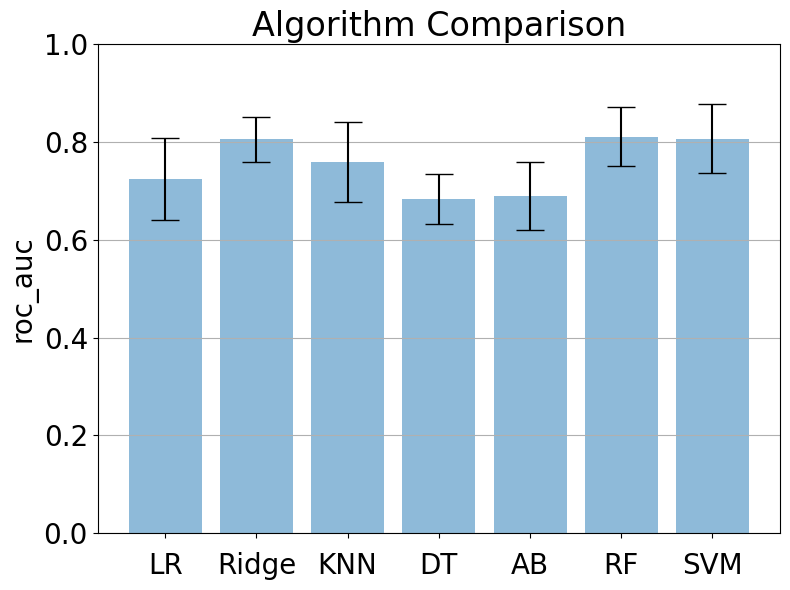

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X=df_combined_imputed[all_feats_final]
y=le.fit_transform(df_combined_imputed['outcome'])

print(X.shape)

np.random.seed(100)
testAlgorgithms(X=X, y=y,
                condition="testModels_lowN_AUC",
                path=fig_path, scoring='roc_auc')



LR
Ridge
KNN
DT
AB
RF
SVM


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
FixedFormatter should only be used together with FixedLocator


             LR     Ridge       KNN        DT        AB        RF       SVM
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000
mean   0.777550  0.795814  0.708124  0.689260  0.808880  0.825816  0.794026
std    0.037240  0.030005  0.028308  0.018823  0.035323  0.032233  0.031992
min    0.734020  0.751402  0.678566  0.663852  0.757222  0.787419  0.757543
25%    0.756935  0.783606  0.699058  0.677818  0.793372  0.816714  0.780629
50%    0.778958  0.799829  0.703643  0.690716  0.812551  0.818275  0.787619
75%    0.783845  0.815795  0.704176  0.704468  0.835501  0.830675  0.800281
max    0.833994  0.828440  0.755175  0.709444  0.845753  0.875997  0.844058


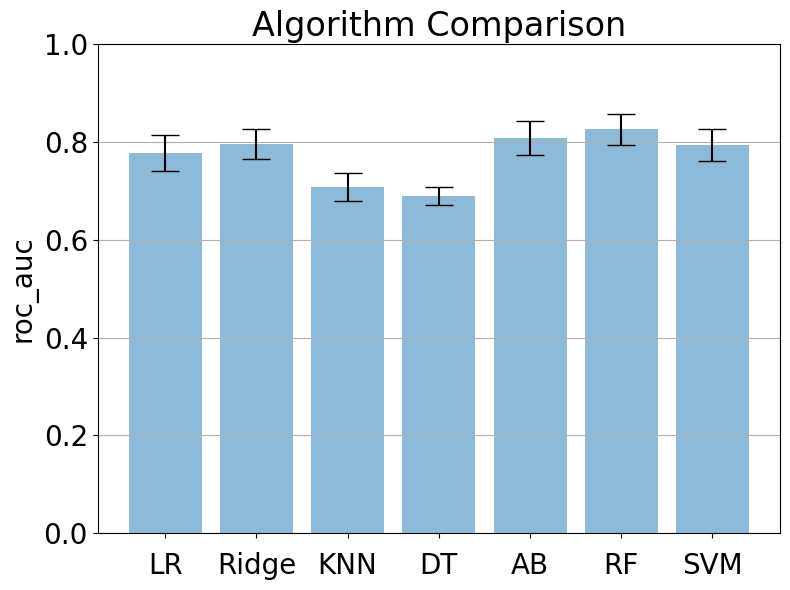

In [ ]:
# repeat for highN
X=df_combined_highN_imputed[all_feats_final]
y=le.fit_transform(df_combined_highN_imputed['outcome'])

np.random.seed(100)
testAlgorgithms(X=X, y=y,
                condition="testModel_highN_AUC",
                path=fig_path, scoring='roc_auc')

In [ ]:
# # run ML w/ class_weight="balanced"
X=df_combined_highN_imputed[all_feats_final]
y=df_combined_highN_imputed['outcome']

X_train_highN, X_val_highN, y_train_highN, y_val_highN = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=123)

[integrated_model, integrated_scores] = train_model(X=X_train_highN,
                                      y=y_train_highN,
                                      condition="Integrated_model_highN",
                                      fig_path=fig_path,
                                      num_folds=5, num_iter=10,
                                      class_names=['Failure','Success'],
                                      pos_label=0, confusion_labels=True,
                                      random_seed=123,  tune=True,
                                      importance=False, class_weight="balanced",
                                      figsize=(3,3),
                                      title="Cross validation (training set)")
integrated_scores.mean()

Training new model!!!
Number of class: 2
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Directory already created


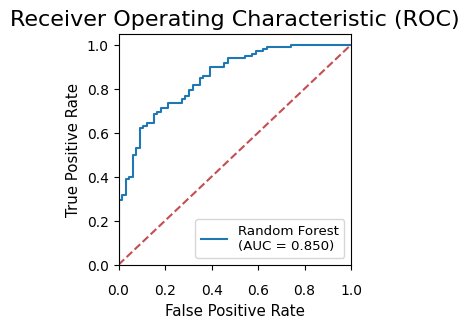

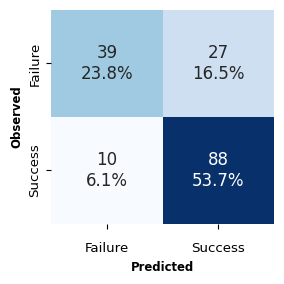

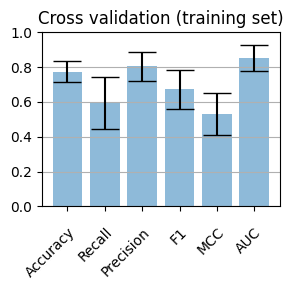

Fit Time: 73.67283868789673


Accuracy     0.793135
Recall       0.548373
Precision    0.726700
F1           0.624449
MCC          0.495153
AUC          0.825888
dtype: float64

In [ ]:
# # run ML w/ class_weight="balanced"
X=df_combined_imputed[all_feats_final]
y=df_combined_imputed['outcome']

X_train_lowN, X_val_lowN, y_train_lowN, y_val_lowN = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=123)

[integrated_lowN_model, integrated_lowN_scores] = train_model(X=X_train_lowN,
                                      y=y_train_lowN,
                                      condition="Integrated_model_lowN",
                                      fig_path=fig_path,
                                      num_folds=5, num_iter=10,
                                      class_names=['Failure','Success'],
                                      pos_label=0, confusion_labels=True,
                                      random_seed=123,  tune=True,
                                      importance=False, class_weight="balanced",
                                      figsize=(3,3),
                                      title="Cross validation (training set)")
integrated_scores.mean()

In [ ]:
# DR model

df_combined_highN_dr = df_combined_highN_imputed[df_combined_highN_imputed['type_of_resistance']!=1]

X=df_combined_highN_dr[all_feats_final]
y=df_combined_highN_dr['outcome']

X_train_int_dr, X_val_int_dr, y_train_int_dr, y_val_int_dr = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=123)
print(X_train_int_dr.shape)
print(X_val_int_dr.shape)

# [integrated_dr_model, integrated_dr_scores] = train_model(X=X_train_int_dr,
#                                       y=y_train_int_dr,
#                                       condition="Integrated_model_DR",
#                                       fig_path='2023_revisions',
#                                       num_folds=5, num_iter=10,
#                                       class_names=['Failure','Success'],
#                                       pos_label=0, confusion_labels=True,
#                                       random_seed=123,  tune=True,
#                                       importance=False, class_weight="balanced",
#                                       figsize=(3,3),
#                                       title="Cross validation (training set)")
# integrated_dr_scores.mean()

# dill.dump_session('./final_TB_workspace_Sept2023.pkl')


(1577, 163)
(395, 163)


### Validate integrated models on 20% test set

In [ ]:
# validate full model
print("Integrated test set:")
test_my_model(integrated_model,
              X_val_int,
              y_val_int,
              "integrated_20%_validation")

# validate DR model
print("Integrated DR test set:")
test_my_model(integrated_dr_model,
              X_val_int_dr,
              y_val_int_dr,
              "integrated_DR_20%_validation")



In [ ]:
dill.dump_session('./final_TB_workspace_May2023.pkl')


### Validate on external patients

In [ ]:
# start with xray data
df_combined_ext = df_pathogen_imputed_val[features_pathogen_final+['patient_id','outcome']]
print(df_combined_ext.shape)

# add social
df_combined_ext = df_combined_ext.merge(df_social_imputed_val[features_social_final+['patient_id']],
                                  on='patient_id', how='inner')
print(df_combined_ext.shape)


# add xray
df_combined_ext = df_combined_ext.merge(df_xray_lowMiss_val[features_xray_final+['patient_id','outcome']],
                                  on='patient_id', how='inner')
# fix outcome
df_combined_ext['outcome'] = df_combined_ext['outcome_x'].fillna(df_combined_ext['outcome_y'])

print(df_combined_ext.shape)


(388, 30)
(388, 42)
(304, 168)


In [ ]:
df_combined_ext_dr = df_combined_ext[df_combined_ext.type_of_resistance != 1]
df_combined_ext_dr.shape

(195, 168)

In [ ]:
# validate full model
print("Integrated validation set:")
test_my_model(integrated_model,
              df_combined_ext[all_feats_final],
              df_combined_ext['outcome'],
              "integrated_external_validation")

# validate DR model
print("Integrated DR validation set:")
test_my_model(integrated_model,
              df_combined_ext_dr[all_feats_final],
              df_combined_ext_dr['outcome'],
              "integrated_external_validation_DR")


## ML: Train dataset-specific models (full population)

In [ ]:
# create training and test sets
X_train_social, X_val_social, y_train_social, y_val_social = train_test_split(df_social_imputed[features_social_highVar],
                                                                      df_social_imputed['outcome'],
                                                                      test_size = 0.2,
                                                                      stratify=df_social_imputed['outcome'],
                                                                      random_state=123)

X_train_pathogen, X_val_pathogen, y_train_pathogen, y_val_pathogen = train_test_split(df_pathogen_imputed[features_pathogen_highVar],
                                                                      df_pathogen_imputed['outcome'],
                                                                      test_size = 0.2,
                                                                      stratify=df_pathogen_imputed['outcome'],
                                                                      random_state=123)

X_train_ct, X_val_ct, y_train_ct, y_val_ct = train_test_split(df_ct_imputed[features_ct_highVar],
                                                            df_ct_imputed['outcome'],
                                                            test_size = 0.2,
                                                            stratify=df_ct_imputed['outcome'],
                                                            random_state=123)

X_train_xray, X_val_xray, y_train_xray, y_val_xray = train_test_split(df_xray_lowMiss[features_xray_highVar],
                                                                      df_xray_lowMiss['outcome'],
                                                                      test_size = 0.2,
                                                                      stratify=df_xray_lowMiss['outcome'],
                                                                      random_state=123)


In [ ]:
[social_model, social_scores] = train_model(X=X_train_social, y=y_train_social,
                                            condition="AllPatients_Social", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
social_scores.mean()

Training new model!!!
Number of class: 2
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Directory already created


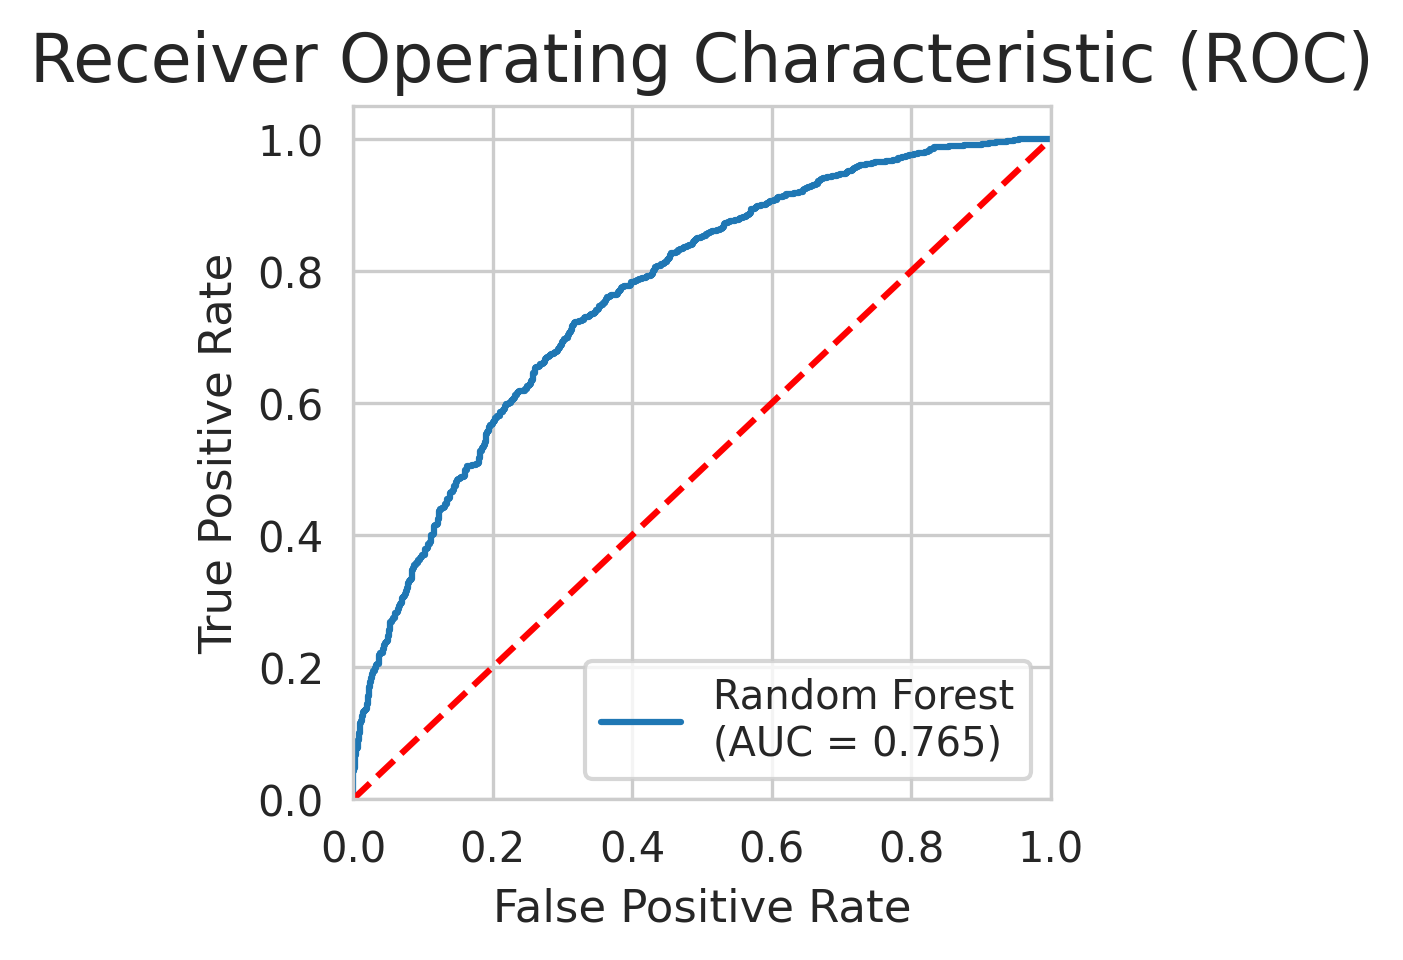

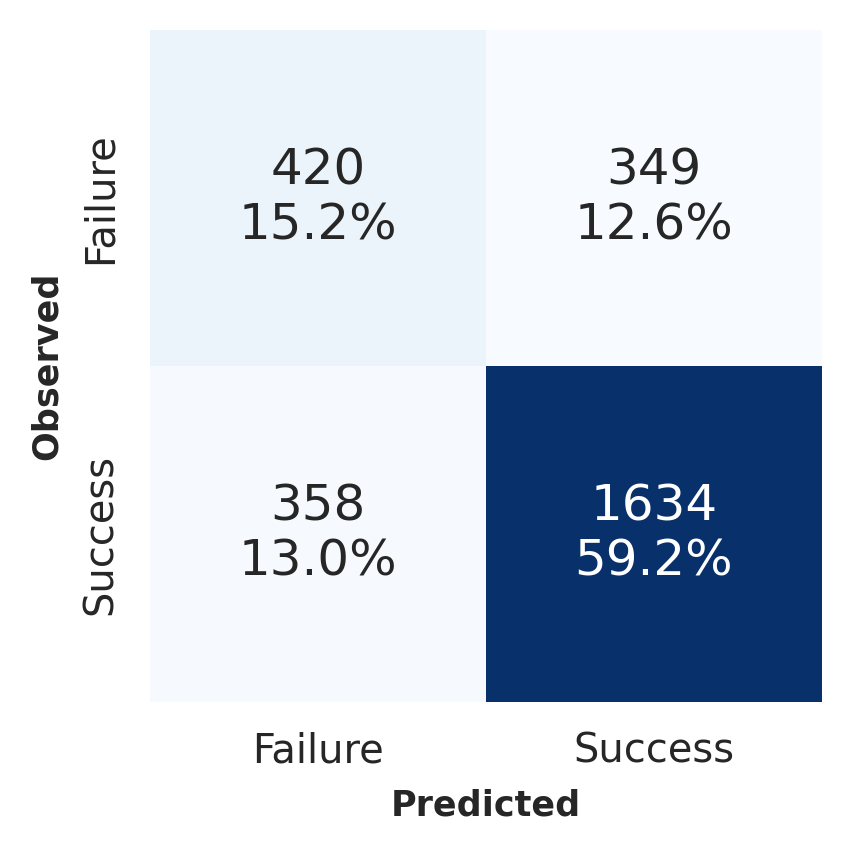

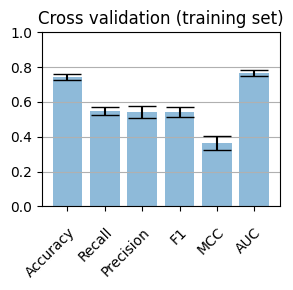

Fit Time: 124.78610253334045
Accuracy     0.741394
Recall       0.534360
Precision    0.535885
F1           0.534855
MCC          0.356013
AUC          0.763992
dtype: float64
Accuracy     0.743929
Recall       0.546125
Precision    0.540694
F1           0.543205
MCC          0.365505
AUC          0.765333
dtype: float64


In [ ]:
feats_noComorbid = [ele for ele in features_social_highVar if ele not in "comorbidity"]

X_train_noComorbid = X_train_social.drop(['comorbidity'], axis=1,inplace=False)


[social_noComorbid_model, social_noComorbid_scores] = train_model(X=X_train_noComorbid, y=y_train_social,
                                            condition="AllPatients_SocialNoComorbid", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
print(social_scores.mean())
print(social_noComorbid_scores.mean())

In [ ]:
len(np.unique(X_train_social.comorbidity))

99

In [ ]:
dill.dump_session('./final_TB_workspace_Sept2023.pkl')


In [ ]:
[pathogen_model, pathogen_scores] = train_model(X=X_train_pathogen, y=y_train_pathogen,
                                            condition="AllPatients_Pathogen", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
pathogen_scores.mean()

In [ ]:
[ct_model, ct_scores] = train_model(X=X_train_ct, y=y_train_ct,
                                            condition="AllPatients_CT", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
ct_scores.mean()

In [ ]:
[xray_model, xray_scores] = train_model(X=X_train_xray, y=y_train_xray,
                                            condition="AllPatients_Xray", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
xray_scores.mean()


In [ ]:
# save workspace
dill.dump_session('./final_TB_workspace_Sept2023.pkl')


### Look at drug-resistant only patients

In [ ]:
social_resistances = df_social_encoded[['patient_id', 'type_of_resistance']]
pathogen_resistances = df_pathogen_encoded[['patient_id', 'type_of_resistance']]
ct_resistances = df_ct_encoded[['patient_id', 'type_of_resistance']]
xray_resistances = pathogen_resistances[pathogen_resistances['patient_id'].isin(df_xray_uniq['patient_id'])]

In [ ]:
df_social_wResist = df_social_imputed.merge(social_resistances, on='patient_id', how='inner')
df_pathogen_wResist = df_pathogen_imputed.merge(pathogen_resistances, on='patient_id', how='inner')
df_ct_wResist = df_ct_imputed.merge(ct_resistances, on='patient_id', how='inner')
df_xray_wResist = df_xray_lowMiss.merge(xray_resistances, on='patient_id', how='inner')

In [ ]:
df_social_dr = df_social_wResist[df_social_wResist['type_of_resistance']!=1]
df_pathogen_dr = df_pathogen_imputed[df_pathogen_imputed['type_of_resistance']!=1]
df_ct_dr = df_ct_wResist[df_ct_wResist['type_of_resistance']!=1]
df_xray_dr = df_xray_wResist[df_xray_wResist['type_of_resistance']!=1]

In [ ]:
# create training and test sets
X_train_social_dr, X_val_social_dr, y_train_social_dr, y_val_social_dr = train_test_split(df_social_dr[features_social_highVar],
                                                                      df_social_dr['outcome'],
                                                                      test_size = 0.2,
                                                                      stratify=df_social_dr['outcome'],
                                                                      random_state=123)

X_train_pathogen_dr, X_val_pathogen_dr, y_train_pathogen_dr, y_val_pathogen_dr = train_test_split(df_pathogen_dr[features_pathogen_highVar],
                                                                      df_pathogen_dr['outcome'],
                                                                      test_size = 0.2,
                                                                      stratify=df_pathogen_dr['outcome'],
                                                                      random_state=123)

X_train_ct_dr, X_val_ct_dr, y_train_ct_dr, y_val_ct_dr = train_test_split(df_ct_dr[features_ct_highVar],
                                                            df_ct_dr['outcome'],
                                                            test_size = 0.2,
                                                            stratify=df_ct_dr['outcome'],
                                                            random_state=123)

X_train_xray_dr, X_val_xray_dr, y_train_xray_dr, y_val_xray_dr = train_test_split(df_xray_dr[features_xray_highVar],
                                                                      df_xray_dr['outcome'],
                                                                      test_size = 0.2,
                                                                      stratify=df_xray_dr['outcome'],
                                                                      random_state=123)

In [ ]:
print(X_val_social_dr.shape)
print(X_val_pathogen_dr.shape)
print(X_val_xray_dr.shape)
print(X_val_ct_dr.shape)
# print(X_val_highN.shape)


(561, 12)
(388, 28)
(53, 124)
(186, 20)


In [ ]:
[social_model_dr, social_scores_dr] = train_model(X=X_train_social_dr, y=y_train_social_dr,
                                            condition="AllPatients_Social_dr", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
social_scores_dr.mean()

In [ ]:
[pathogen_model_dr, pathogen_scores_dr] = train_model(X=X_train_pathogen_dr, y=y_train_pathogen_dr,
                                            condition="AllPatients_Pathogen_dr", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (training set)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
pathogen_scores_dr.mean()

In [ ]:
[ct_model_dr, ct_scores_dr] = train_model(X=X_train_ct_dr, y=y_train_ct_dr,
                                            condition="AllPatients_CT_dr", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (drug-resistant)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
ct_scores_dr.mean()

In [ ]:
[xray_model_dr, xray_scores_dr] = train_model(X=X_train_xray_dr, y=y_train_xray_dr,
                                            condition="AllPatients_Xray_dr", fig_path=fig_path,
                                            num_folds=5, num_iter=10,
                                            random_seed=123,  tune=True,
                                            importance=False, class_weight="balanced", show=True,
                                            title="Cross validation (drug-resistant)",
                                            confusion_labels=True, class_names=['Failure','Success'],
                                            pos_label=0, figsize=(3,3)
)
xray_scores_dr.mean()


## Testing models on 20% holdout dataset

### All-patient models

In [ ]:
from sklearn.metrics import (roc_auc_score, r2_score, mean_squared_error, roc_curve, auc)

def test_my_model(model,
                  X_test, y_test,
                  name,
                  class_names = ['Failure','Success'],
                  my_title="Model evaluation (validation set)",
                  my_font_size=20,
                  figsize=(4,4)):

  y_pred = model.predict(X_test)
  y_true_encoded = le.fit_transform(y_test)

  make_confusion_matrix(y_true_encoded, y_pred, figsize=figsize, categories=class_names,
                        xyplotlabels=True, cbar=False, sum_stats=True, pos_label=0, fontsize=my_font_size)
  plt.title(my_title, fontsize=my_font_size)
  # plt.tight_layout()
  plt.savefig(fig_path+"/{}.pdf".format(name),
                  format="pdf", dpi=600, bbox_inches="tight")
  plt.show()

  # AUC
  y_proba = model.predict_proba(X_test)
  y_proba = y_proba[:, 1]
  auc = roc_auc_score(y_true_encoded, y_proba)
  print("AUC: {}".format(auc))

In [ ]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

In [ ]:
print("Social test set:")
test_my_model(social_model, X_val_social, y_val_social, "holdout_20%_test_social")

print("Pathogen test set:")
test_my_model(pathogen_model, X_val_pathogen, y_val_pathogen, "holdout_20%_test_pathogen")

print("CT test set:")
test_my_model(ct_model, X_val_ct, y_val_ct, "holdout_20%_test_ct")

print("Xray test set:")
test_my_model(xray_model, X_val_xray, y_val_xray, "holdout_20%_test_xray")

### Repeat for DR models

In [ ]:
print("Social test set (DR):")
test_my_model(social_model_dr, X_val_social_dr, y_val_social_dr, "holdout_20%_test_social_dr")

print("Pathogen test set (DR):")
test_my_model(pathogen_model_dr, X_val_pathogen_dr, y_val_pathogen_dr, "holdout_20%_test_pathogen_dr")

print("CT test set (DR):")
test_my_model(ct_model_dr, X_val_ct_dr, y_val_ct_dr, "holdout_20%_test_ct_dr")

print("Xray test set (DR):")
test_my_model(xray_model_dr, X_val_xray_dr, y_val_xray_dr, "holdout_20%_test_xray_dr")

## Validate external datasets

In [ ]:
# repeat data cleaning steps - df_social_validate, df_pathogen_validate, df_xray_validate

# remove patients w/ >70% missing
threshold = 0.7

# Social
rows_lowMiss = (df_social_validate[features_social_highVar].isnull().sum(axis = 1) / len(features_social_highVar)) <= threshold
df_social_lowMiss_val = df_social_validate[rows_lowMiss].reset_index()
print("Social dataset: {} to {} patients...".format(df_social_validate.shape[0], df_social_lowMiss_val.shape[0]))

# Pathogen
rows_lowMiss = (df_pathogen_validate[features_pathogen_highVar].isnull().sum(axis = 1) / len(features_pathogen_highVar)) <= threshold
df_pathogen_lowMiss_val = df_pathogen_validate[rows_lowMiss].reset_index()
print("Pathogen dataset: {} to {} patients...".format(df_pathogen_validate.shape[0], df_pathogen_lowMiss_val.shape[0]))

# xray
rows_lowMiss = (df_xray_validate[features_xray_highVar].isnull().sum(axis = 1) / len(features_xray_highVar)) <= threshold
df_xray_lowMiss_val = df_xray_validate[rows_lowMiss].reset_index()
print("Xray dataset: {} to {} patients...".format(df_xray_validate.shape[0], df_xray_lowMiss_val.shape[0]))

# CT
rows_lowMiss = (df_ct_validate[features_ct_highVar].isnull().sum(axis = 1) / len(features_ct_highVar)) <= threshold
df_ct_lowMiss_val = df_ct_validate[rows_lowMiss].reset_index()
df_ct_lowMiss_val.dropna(subset = ['outcome'], inplace=True)
print("CT dataset: {} to {} patients...".format(df_ct_validate.shape[0], df_ct_lowMiss_val.shape[0]))
print(Counter(df_ct_lowMiss_val.outcome))

Social dataset: 491 to 491 patients...
Pathogen dataset: 491 to 388 patients...
Xray dataset: 373 to 373 patients...
CT dataset: 7540 to 103 patients...
Counter({'Success': 84, 'Failure': 19})


In [ ]:
# impute

# Social
imputer.fit(df_social_lowMiss[features_social_highVar])
df_social_imputed_val = pd.DataFrame(imputer.transform(df_social_lowMiss_val[features_social_highVar]),columns=features_social_highVar)
df_social_imputed_val['patient_id'] = df_social_lowMiss_val['patient_id']
df_social_imputed_val['outcome'] = df_social_lowMiss_val['outcome']
print("Social dataset: from {} to {} missing values...".format(df_social_lowMiss_val[features_social_highVar].isnull().sum().sum(),
                                                               df_social_imputed[features_social_highVar].isnull().sum().sum()))
# Pathogen
imputer.fit(df_pathogen_lowMiss[features_pathogen_highVar])
df_pathogen_imputed_val = pd.DataFrame(imputer.transform(df_pathogen_lowMiss_val[features_pathogen_highVar]),columns=features_pathogen_highVar)
df_pathogen_imputed_val['patient_id'] = df_pathogen_lowMiss_val['patient_id']
df_pathogen_imputed_val['outcome'] = df_pathogen_lowMiss_val['outcome']
print("Pathogen dataset: from {} to {} missing values...".format(df_pathogen_lowMiss_val[features_pathogen_highVar].isnull().sum().sum(),
                                                               df_pathogen_imputed_val[features_pathogen_highVar].isnull().sum().sum()))
# CT
imputer.fit(X_train_ct)
df_ct_imputed_val = pd.DataFrame(imputer.transform(df_ct_lowMiss_val[features_ct_highVar]),columns=features_ct_highVar)
df_ct_imputed_val['patient_id'] = df_ct_lowMiss_val['patient_id']
df_ct_imputed_val['outcome'] = df_ct_lowMiss_val['outcome']
df_ct_imputed_val.dropna(subset = ['outcome'], inplace=True)
print("CT dataset: from {} to {} missing values...".format(df_ct_lowMiss_val[features_ct_highVar].isnull().sum().sum(),
                                                               df_ct_imputed_val[features_ct_highVar].isnull().sum().sum()))



Social dataset: from 1555 to 0 missing values...
Pathogen dataset: from 6065 to 0 missing values...
CT dataset: from 472 to 0 missing values...


In [ ]:
dill.dump_session('./final_TB_workspace_Sept2023.pkl')


In [ ]:
fig, axes = plt.subplots(2, 2)

#create chart in each subplot
sns.countplot(data=df_social_imputed_val, x='outcome', ax=axes[0,0])
sns.countplot(data=df_pathogen_imputed_val, x='outcome', ax=axes[0,1])
sns.countplot(data=df_ct_imputed_val, x='outcome', ax=axes[1,0])
sns.countplot(data=df_xray_validate, x='outcome', ax=axes[1,1])
plt.show()

### Separate validation datasets by drug-resistance

In [ ]:
social_resistances_val = df_social_validate[['patient_id', 'type_of_resistance']]
print(Counter(social_resistances_val.type_of_resistance))

pathogen_resistances_val = df_pathogen_validate[['patient_id', 'type_of_resistance']].dropna()
print(Counter(pathogen_resistances_val.type_of_resistance))

ct_resistances_val = df_ct_validate[['patient_id', 'type_of_resistance']]
print(Counter(ct_resistances_val.type_of_resistance))

df_xray_validate = df_xray_validate.rename(columns={"Patient_id": "patient_id", "Type of resistance": "type_of_resistance"})
xray_resistances_val = df_xray_validate[['patient_id', 'type_of_resistance']]
print(Counter(xray_resistances_val.type_of_resistance))


Counter({1.0: 170, 4.0: 161, 2.0: 69, 6.0: 46, 5.0: 25, 3.0: 20})
Counter({1.0: 170, 6.0: 45, 5.0: 25})
Counter({'MDR non XDR': 3336, 'Sensitive': 2257, 'XDR': 902, 'Mono DR': 597, 'Pre-XDR': 236, 'Poly DR': 211, 'Negative': 1})
Counter({'Sensitive': 166, 'MDR non XDR': 112, 'XDR': 39, 'Mono DR': 28, 'Pre-XDR': 22, 'Poly DR': 6})


In [ ]:
df_social_wResist_val = df_social_imputed_val.merge(social_resistances_val, on='patient_id', how='inner')
df_ct_wResist = df_ct_imputed_val.merge(ct_resistances_val, on='patient_id', how='inner')

df_social_dr_val= df_social_wResist_val[df_social_wResist_val['type_of_resistance']!=1]
df_pathogen_dr_val = df_pathogen_imputed_val[df_pathogen_imputed_val['type_of_resistance']!=1]
df_ct_dr_val = df_ct_wResist[df_ct_wResist['type_of_resistance']!="Sensitive"]
df_xray_dr_val = df_xray_lowMiss_val[df_xray_lowMiss_val['type_of_resistance']!="Sensitive"]

print(df_social_dr_val.shape)
print(df_pathogen_dr_val.shape)
print(df_xray_dr_val.shape)
print(df_ct_dr_val.shape)

(321, 15)
(279, 30)
(207, 132)
(61, 23)


### Test all-patient models

In [ ]:
print("Social test set:")
test_my_model(social_model,
              df_social_imputed_val[features_social_highVar],
              df_social_imputed_val['outcome'],
              "external_test_social")

print("Pathogen test set:")
test_my_model(pathogen_model,
              df_pathogen_imputed_val[features_pathogen_highVar],
              df_pathogen_imputed_val['outcome'],
              "external_test_pathogen")

print("Xray test set:")
test_my_model(xray_model,
              df_xray_lowMiss_val[features_xray_highVar],
              df_xray_lowMiss_val['outcome'],
              "external_test_xray")

print("CT test set:")
test_my_model(ct_model,
              df_ct_imputed_val[features_ct_highVar],
              df_ct_imputed_val['outcome'],
              "external_test_CT")

### Test DR models

In [ ]:
print("Social test set (DR):")
test_my_model(social_model_dr,
              df_social_dr_val[features_social_highVar],
              df_social_dr_val['outcome'],
              "external_test_social_dr")

print("Pathogen test set (DR):")
test_my_model(pathogen_model_dr,
              df_pathogen_dr_val[features_pathogen_highVar],
              df_pathogen_dr_val['outcome'],
              "external_test_pathogen_dr")

print("Xray test set (DR):")
test_my_model(xray_model_dr,
              df_xray_dr_val[features_xray_highVar],
              df_xray_dr_val['outcome'],
              "external_test_xray_dr")

print("CT test set (DR):")
test_my_model(ct_model_dr,
              df_ct_dr_val[features_ct_highVar],
              df_ct_dr_val['outcome'],
              "external_test_xray_dr")

In [ ]:
# dill.load_session('./final_TB_workspace_May2023.pkl')
# dill.dump_session('./final_TB_workspace_May2023.pkl')


## Decision tree model

In [ ]:
# decision tree functions
# if 'google.colab' in sys.modules:
!pip install -q dtreeviz

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import copy
from sklearn.tree._tree import TREE_LEAF
from sklearn import tree
from sklearn.metrics import matthews_corrcoef

def prune(tree):
    '''
    This function will get rid of repetitive branches in decision trees
    which lead to the same class prediciton.
    Function written by GitHub user davidje13 (https://github.com/scikit-learn/scikit-learn/issues/10810)

    Function Inputs:
    ---------
    tree:   decision tree classifier

    Function Outputs:
    ---------
    tree:   pruned decision tree classifier
    '''
    tree = copy.deepcopy(tree)
    dat = tree.tree_
    nodes = range(0, dat.node_count)
    ls = dat.children_left
    rs = dat.children_right
    classes = [[list(e).index(max(e)) for e in v] for v in dat.value]
    leaves = [(ls[i] == rs[i]) for i in nodes]
    LEAF = -1
    for i in reversed(nodes):
        if leaves[i]:
            continue
        if leaves[ls[i]] and leaves[rs[i]] and classes[ls[i]] == classes[rs[i]]:
            ls[i] = rs[i] = LEAF
            leaves[i] = True
    return tree



def prune_index(inner_tree, index, threshold):
    '''
    This function will traverse a decision tree and remove any leaves with
    a count class less than the given threshold.
    Function written by David Dale
    (https://stackoverflow.com/questions/49428469/pruning-decision-trees)

    Function Inputs:
    ---------
    inner_tree:   tree object (.tree_) from decision tree classifier
    index:        where to start pruning tree from (0 for the root)
    threshold:    minimum class count in leaf
    '''
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)



def decisionTree(X, y, class_names,
                 weighting="none", weights=None,
                 depths = [3,4],
                 pruneLevel=0, condition="Condition",
                 make_viz=False, random_seed=123,
                 fig_path="../figures/decision_trees/", sub_path=""):
    '''
    Function Inputs:
    ----------
    1. X:            Features matrix
    2. y:            Target variable array
    3. class_names:  String array of class names
    4. weighting:    Options for handling class imbalance
                     a.) "none" (default): no class weights or sampling applied
                     b.) "balanced":       inverse class proportions
                                           used to assign class weights
                     c.) "smote":          SMOTE over-sampling applied
                     d.) "tuned":          weights are tuned via cross-validation
                     e.) list of floats:   floats are used to determine ratio for
                                           SMOTE. Assumed classes 0 and 2 are minority.
                                           (e.g. [0.5 0.75] = sample class 0 to 50%
                                                  of class 1, class 2 to 75% of class 1)
    5. weights       Dictionary of weights to use with the "tuned" weighting
                     option   .
    6. pruneLevel    Integer, designating the minimum number of observations
                     in a leaf for it to be pruned.
    7. condition:    String of dataset condition (for naming plots/files)
    8. make_viz:     Whether to make additional tree figure using dtree_viz package.
    9. random_seed:  Random seed for tuning decision trees.
   10. fig_path:     Path for saving decision tree figures. Default is "../figures/decision_trees"
   11. sub_path:     Sub-folder name for keeping figures organized. If none is
                     given, all  figures saved in fig_path.


    Function Outputs:
    ----------
    Decision tree plots are saved to the 'figures/decision_trees' folder.
'''
    # define path name for saving trees
    path = fig_path+sub_path

    try:
        os.mkdir(path)
    except OSError:
        print("Creation of the directory %s failed" % path)
    else:
        print("Successfully created the directory %s " % path)

    # create Dtrees at multiple depths
    treeDict_VarDepths = {}

    param_dist = {"min_samples_leaf": [1, 3, 5, 10, 20],  # default=1, range:1-20
                  # default=2, range:1-40
                  "min_samples_split": [2, 3, 5, 10, 25],
                  "criterion": ["gini", "entropy"],
                  "max_features": ["sqrt", "log2", None]}

    # define weights if not given
    if weights is None:
        weights = [{-1: 2, 0: 1, 1: 2}, {-1: 4, 0: 1, 1: 4},
                   {-1: 4, 0: 1, 1: 2}, {-1: 10, 0: 1, 1: 5}]

    feats = X.columns
    y = le.fit_transform(y)

    for i, depth in enumerate(depths):
        print("Training tree with depth {}".format(depth))

        if weighting == "balanced":
            dtree = DecisionTreeClassifier(class_weight='balanced',
                                           max_depth=depth,
                                           random_state=random_seed)
            tree_cv = RandomizedSearchCV(dtree, param_dist,
                                         n_iter=30, cv=5,
                                         scoring="f1_macro",
                                         random_state=random_seed)
            tree_cv.fit(X, y,
                        sample_weight=class_weight.compute_sample_weight("balanced", y))
            tree_clf = tree_cv.best_estimator_

        else: # weighting == "none"
            dtree = DecisionTreeClassifier(max_depth=depth,
                                           random_state=random_seed)
            tree_cv = RandomizedSearchCV(dtree, param_dist,
                                         n_iter=30, cv=5,
                                         scoring="f1_macro",
                                         random_state=random_seed)
            tree_cv.fit(X, y)
            tree_clf = tree_cv.best_estimator_

        # get rid of redundant splits
        tree_clf = prune(tree_clf)

        # evaluate model w/ resubstitution
        y_predDT = tree_clf.predict(X)
        mcc = matthews_corrcoef(y, y_predDT)
        print(mcc)

        # prune tree and re-evaluate
        prunedTree_clf = copy.deepcopy(tree_clf)  # create copy of DT to prune
        prune_index(prunedTree_clf.tree_, 0, pruneLevel)   # run prune function
        prunedTree_clf = prune(prunedTree_clf)  # get rid of unnecessary splits

        # store Dtree model
        treeDict_VarDepths[i] = prunedTree_clf

        # evaluate model w/ resubstitution
        yPredPruned = prunedTree_clf.predict(X)
        mccPruned = matthews_corrcoef(y, yPredPruned)
        print("Pruned tree MCC: {}".format(mccPruned))

        # save tree figure
        file_name = "/{}_MaxDepth{}.pdf".format(
            condition, depth)

        fig = plt.figure(figsize=(40, 20))
        _ = tree.plot_tree(prunedTree_clf,
                           feature_names=feats,
                           class_names=class_names,
                           fontsize=14,
                           impurity=False,
                           filled=True)

        plt.title("{} \nMAX DEPTH: {}\n MCC: {:.3f}".format(
            condition, depth, mccPruned), fontsize=36)
        fig.savefig(path+file_name)  # DO NOT USE DPI !!! ###
        plt.show()

        if make_viz is True:
            file_name_viz = "/{}_MaxDepth{}.svg".format(
                condition, depth)
            viz = dtreeviz(prunedTree_clf, X, y,
                           target_name="Outcome",
                           feature_names=feats,
                           class_names=class_names,
                           label_fontsize=14,
                           ticks_fontsize=12,
                           histtype="barstacked")  # barstacked, bar, stripped
            viz.save(path+file_name_viz)
    return tree_clf


In [ ]:
df_combined_imputed[all_feats_final].dtypes

In [ ]:
all_obj_features = list(objList_path) + list(objList_social) + list(objList_ct) + list(objList_xray)

In [ ]:
all_obj_features = list(objList_path) + list(objList_social) + list(objList_ct) + list(objList_xray)
all_obj_features_final = np.unique(intersection(all_obj_features, all_feats_final))

print(len(all_obj_features))
print(len(all_feats_final))
print(len(all_obj_features_final))

df_tree = df_combined_imputed.copy()

df_tree[all_obj_features_final] = df_tree[all_obj_features_final].astype('category')


In [ ]:
# single decision tree model: drug-resistant
class_names = ['Failure','Success']

integrated_dtree = decisionTree(df_tree[all_feats_final],
                        df_tree['outcome'],
                        class_names=class_names,
                          weighting="none",
                          condition = "Dtree_Integrated",
                          fig_path=fig_path,
                          make_viz=False,
                          pruneLevel=5,
                          depths=[3, 4],
                          random_seed=123)

In [ ]:
# train separate model without country and CT features
all_feats_noCountry = [i for i in all_feats_final if i != "country"]

print(len(all_feats_final))
print(len(all_feats_noCountry))

# single decision tree model
class_names = ['Failure','Success']

integrated_dtree = decisionTree(df_tree[all_feats_noCountry],
                        df_tree['outcome'],
                        class_names=class_names,
                          weighting="none",
                          condition = "Dtree_Integrated_NoCountry",
                          fig_path=fig_path,
                          make_viz=False,
                          pruneLevel=5,
                          depths=[4],
                          random_seed=123)

In [ ]:
# repeat for DR
df_tree_DR = df_tree[df_tree['type_of_resistance']!=1]

integrated_dtree = decisionTree(df_tree_DR[all_feats_noCountry],
                        df_tree_DR['outcome'],
                        class_names=class_names,
                          weighting="none",
                          condition = "Dtree_Integrated_NoCountry_DR",
                          fig_path=fig_path,
                          make_viz=False,
                          pruneLevel=5,
                          depths=[4],
                          random_seed=123)


In [ ]:
Counter(df_tree_DR.moxifloxacin)

## Shapley analyses

### Social models

In [ ]:
print("Generating shap values...")
explainer = shap.TreeExplainer(social_model)
shap_values_social = explainer.shap_values(X_val_social)
explainer_object = explainer(X_val_social)
shap_values_fail_social = shap_values_social[0]

# print("Generating DR shap values...")
# explainer_DR = shap.TreeExplainer(social_model_dr)
# shap_values_DR = explainer.shap_values(X_val_social_dr)
# explainer_object_DR = explainer_DR(X_val_social_dr)
# shap_values_fail_DR = shap_values_DR[0]


Generating shap values...


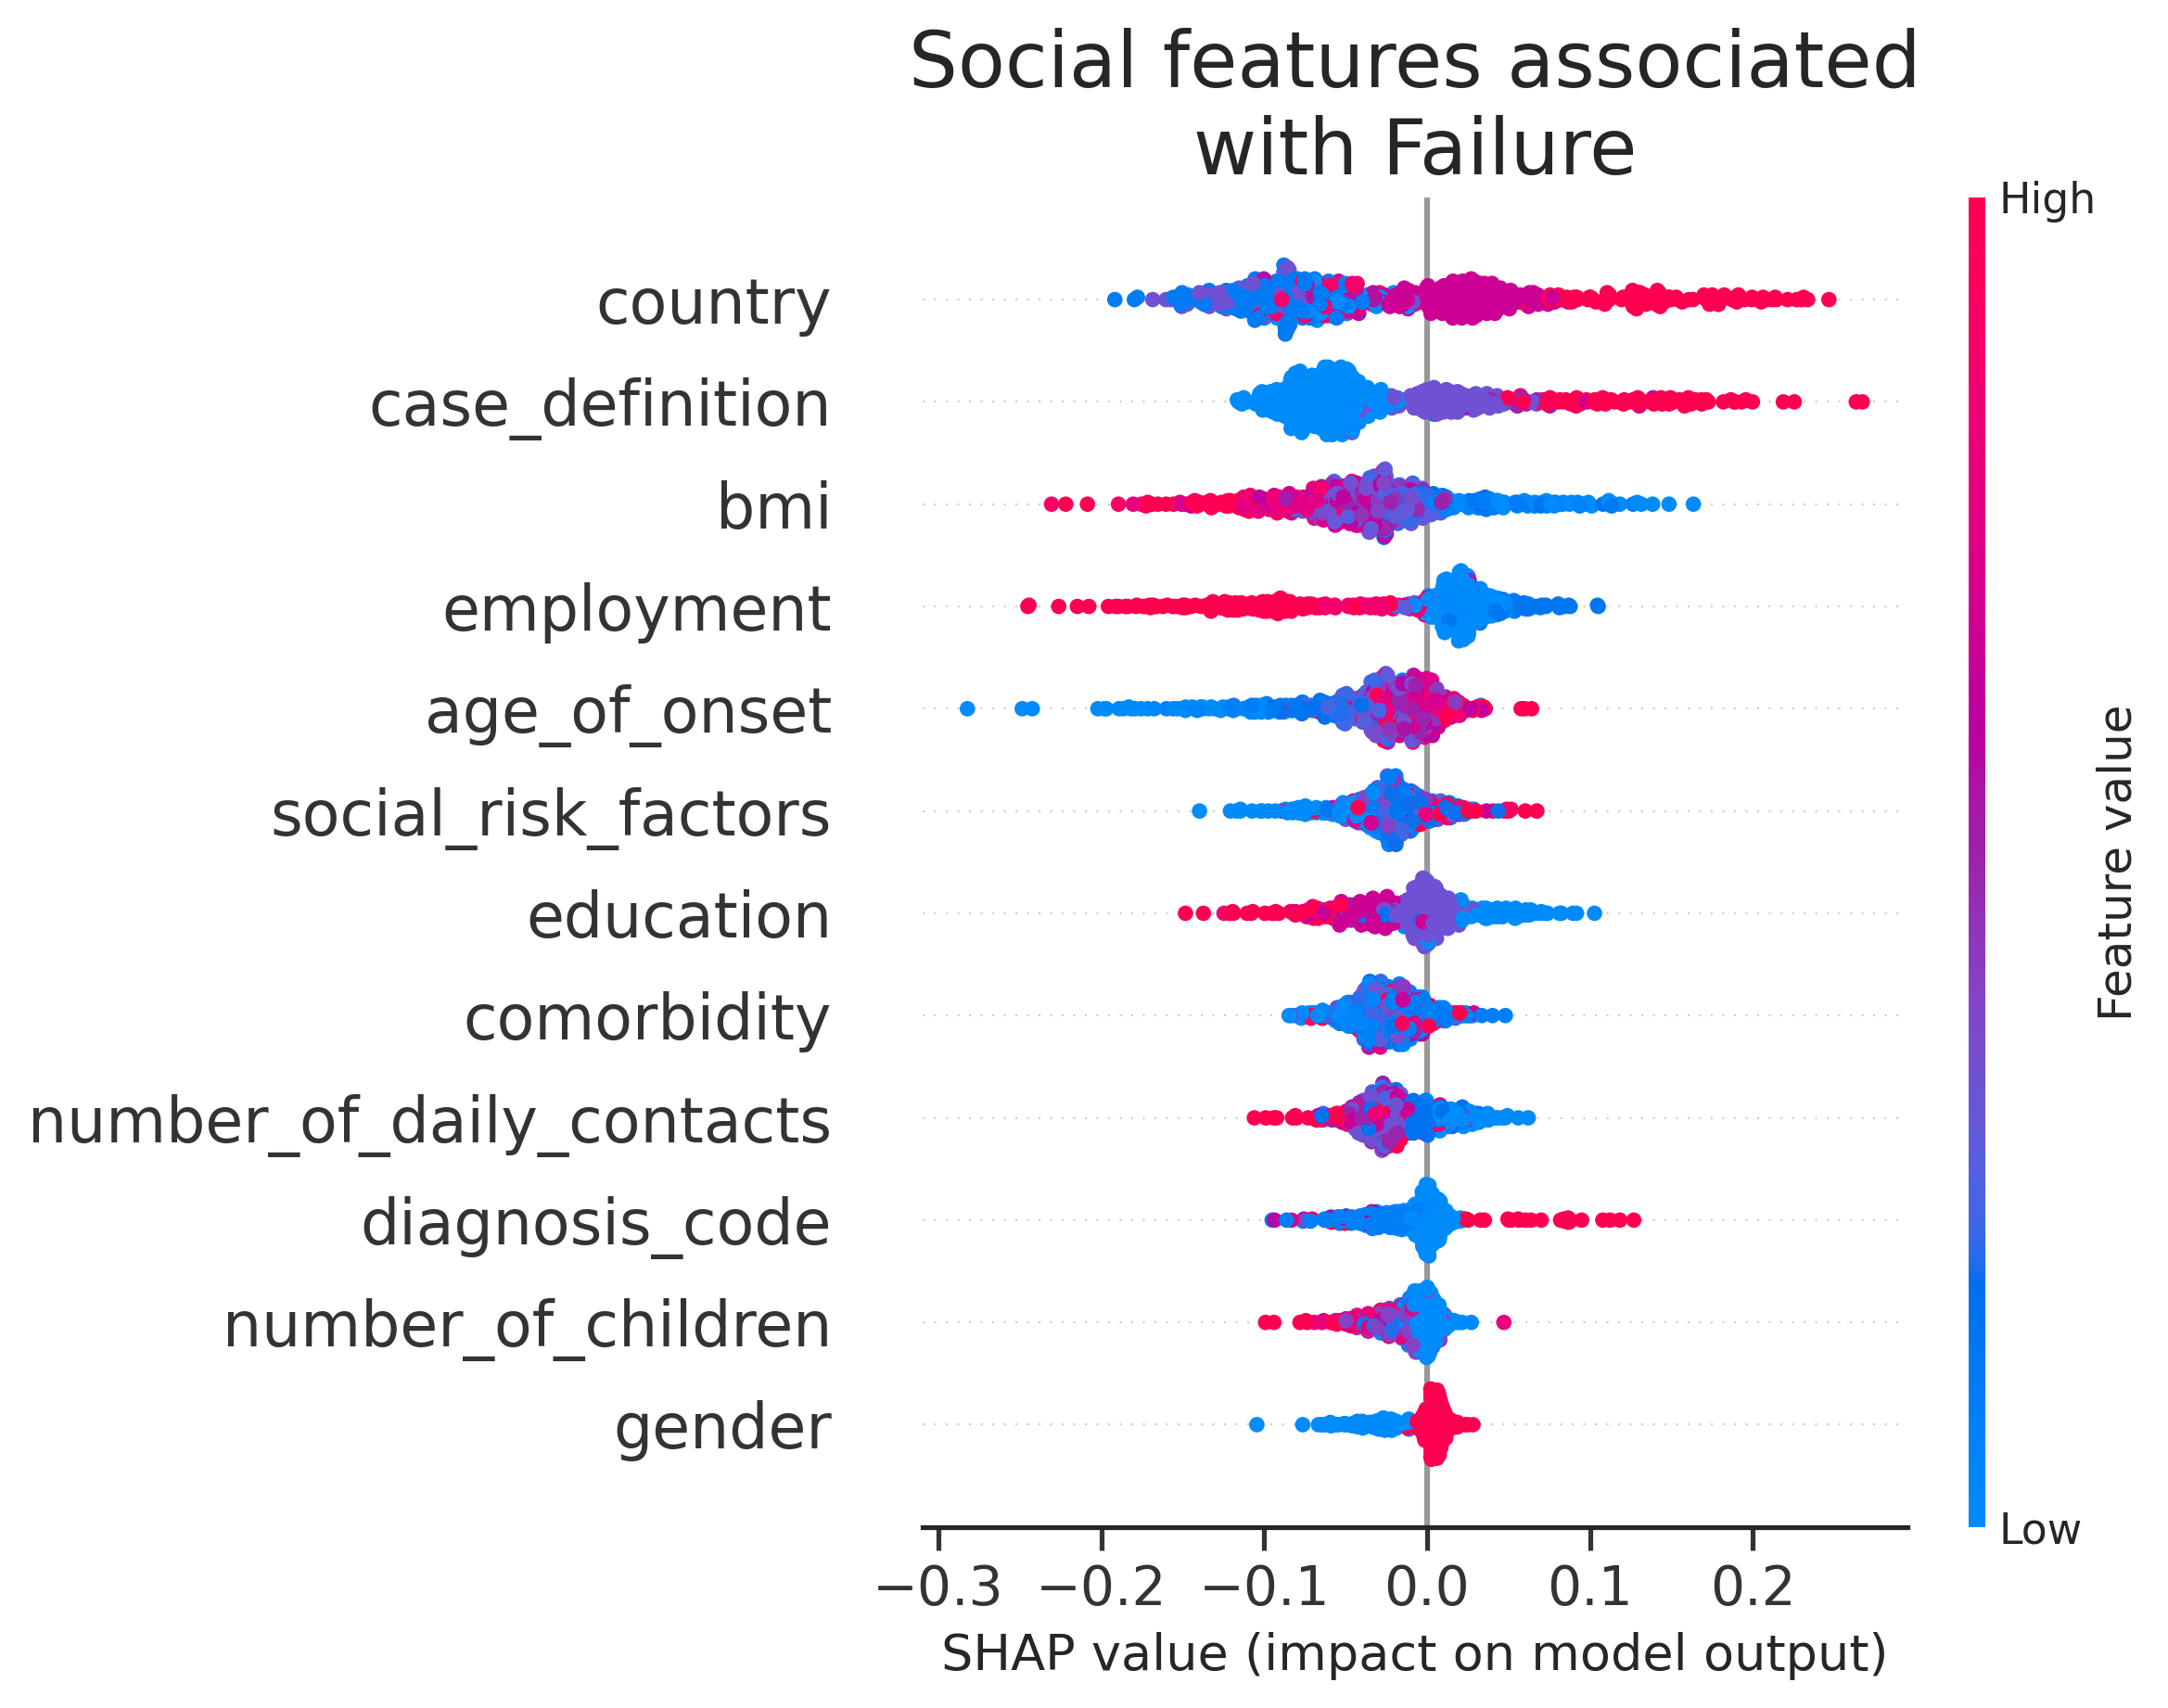

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.rcParams["font.family"] = "DejaVu Sans"
sns.set(style='white')


condition="AllPatients_Social"
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values_fail_social, X_val_social, color_bar=True, show=False)
plt.title("Social features associated\nwith Failure", fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
# plt.xlabel(fontsize=16)
plt.tight_layout()
plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

# # DR
# condition="DR_Social"
# plt.figure(figsize=(5,5))
# shap.summary_plot(shap_values_fail_DR, X_val_social_dr, show=False)
# plt.title("Social features associated\nwith Failure (drug-resistant)", fontsize=20)
# plt.yticks(fontsize=16)
# plt.xticks(np.arange(-0.2, 0.1, 0.1), fontsize=14)
# plt.tight_layout()
# plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
#                 dpi=300)
# plt.show()

### Social features, per country

In [ ]:
# df_social_imputed[features_social_highVar]

# grouping columns
data_country = df_social_imputed.groupby(["country"])
# group size
country_count = pd.DataFrame(data_country.size()).reset_index()
country_count.columns = ["classes","counts"]

df_temp = my_dictionary_social[my_dictionary_social["feature"]=="country"]
country_count = country_count.merge(df_temp).drop(columns=['feature'])
print(country_count)

top_countries = country_count.nlargest(3,'counts').reset_index(drop=True)
# other options for picking countries....
# top_countries = country_count.loc[country_count['categories'].isin(['Azerbaijan', 'Georgia','Romania'])].reset_index(drop=True)
# top_countries = country_count.loc[country_count['classes'].isin([3.0,7.0])]).reset_index(drop=True)

countriesOver100 = country_count[country_count.counts>100].reset_index(drop=True)
print(countriesOver100)

   classes  counts  categories
0      0.0     255  Azerbaijan
1      1.0     864     Belarus
2      2.0      14       China
3      3.0     375     Georgia
4      4.0       5       India
5      5.0     115  Kazakhstan
6      6.0    1124     Moldova
7      7.0       2     Nigeria
8      8.0     210     Romania
9      9.0     488     Ukraine
   classes  counts  categories
0      0.0     255  Azerbaijan
1      1.0     864     Belarus
2      3.0     375     Georgia
3      5.0     115  Kazakhstan
4      6.0    1124     Moldova
5      8.0     210     Romania
6      9.0     488     Ukraine


In [ ]:

feats_noCountry = [ele for ele in features_social_highVar if ele not in "country"]

Xs = list()
country_shap_obj = list()
country_shap_vals = list()

country_scores = pd.DataFrame({'Score':['accuracy','recall','precision','F1','mcc','auc']})
for i in countriesOver100.classes:
  cur_country=countriesOver100.categories[countriesOver100.classes==i].to_string(index = False)
  print(cur_country)

  df_temp = df_social_imputed[df_social_imputed.country==i]
  print(np.shape(df_temp)) # should be 1122 for Moldova

  X_temp = df_temp[feats_noCountry]
  y_temp = df_temp['outcome']

  print(Counter(y_temp))
  # [model_temp, scores_temp] = train_model(X=X_temp, y=y_temp,
  #                                         condition="TB_country_{}".format(cur_country), fig_path=fig_path,
  #                                         num_folds=5, class_names=['Failure','Success'],
  #                                         pos_label=0, random_seed=123, num_iter=5, tune=True,
  #                                         class_weight="balanced", show=False, importance=False)
  # country_scores[cur_country] = np.array(scores_temp.mean())
  # # shap analysis
  # explainer = shap.TreeExplainer(model_temp)
  # shap_values_temp = explainer.shap_values(X_temp)
  # shap_values_obj = explainer(X_temp)

  # # store data and results
  # Xs.append(X_temp)
  # country_shap_obj.append(shap_values_obj)
  # country_shap_vals.append(shap_values_temp)

Azerbaijan
(255, 14)
Counter({'Success': 194, 'Failure': 61})
Belarus
(864, 14)
Counter({'Success': 728, 'Failure': 136})
Georgia
(375, 14)
Counter({'Success': 321, 'Failure': 54})
Kazakhstan
(115, 14)
Counter({'Success': 87, 'Failure': 28})
Moldova
(1124, 14)
Counter({'Success': 735, 'Failure': 389})
Romania
(210, 14)
Counter({'Success': 181, 'Failure': 29})
Ukraine
(488, 14)
Counter({'Failure': 264, 'Success': 224})


In [ ]:
country_scores.to_csv('social_model_byCountry_score.csv')

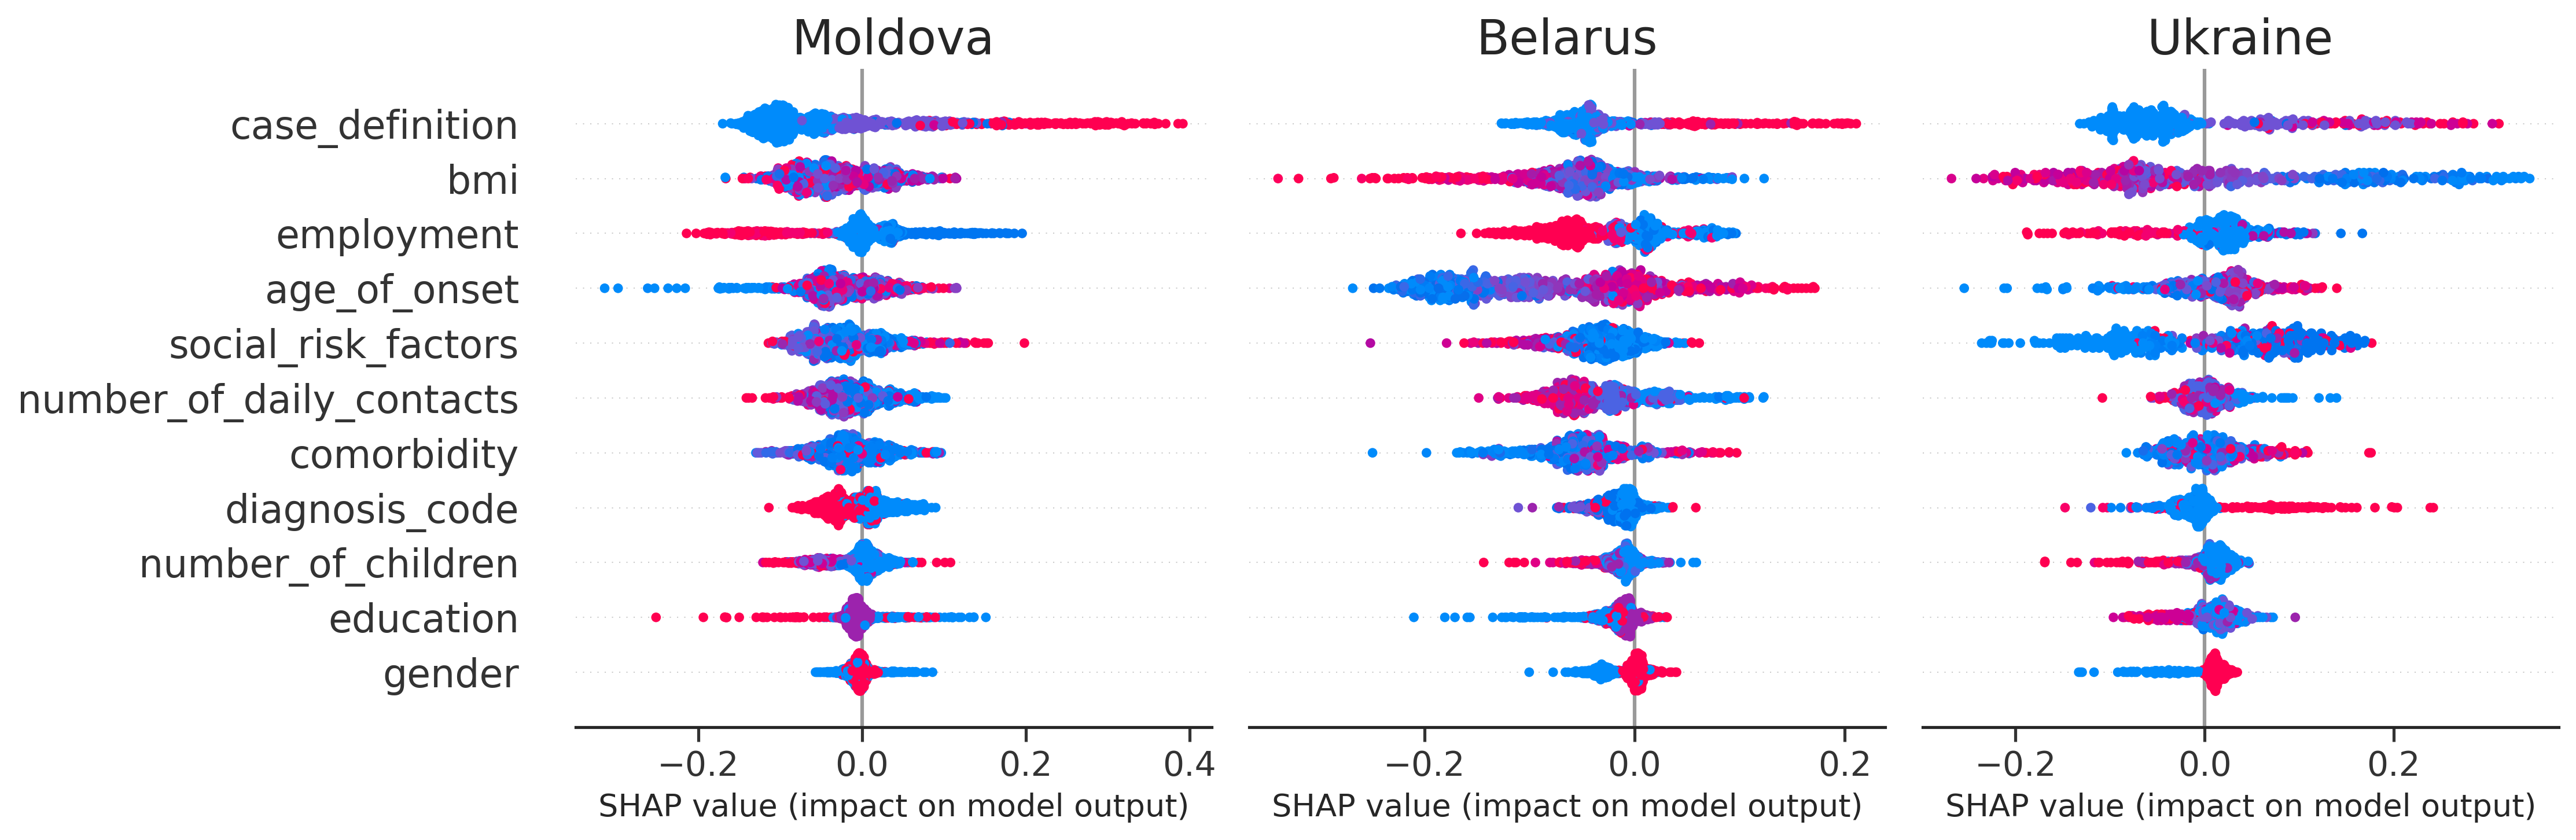

In [ ]:
# plot top 3 countries
# use the feature order from the first country for all figures
condition = "AllPatients_Social"
my_order = country_shap_obj[ix_top3[0]][:,:,0].abs.mean(0)

plt.figure(figsize=(15,5))
ax1=plt.subplot(1,3,1)
shap.plots.beeswarm(country_shap_obj[ix_top3[0]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry), show=False)
ax1.tick_params(axis='y', which='major', labelsize=16)
ax1.tick_params(axis='x', which='major', labelsize=14)
ax1.grid(False)
plt.title(countriesOver100.categories[ix_top3[0]],fontsize=20)

ax2=plt.subplot(1,3,2)
shap.plots.beeswarm(country_shap_obj[ix_top3[1]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry),show=False)
ax2.tick_params(axis='x', which='major', labelsize=14)
plt.title(countriesOver100.categories[ix_top3[1]],fontsize=20)
ax2.grid(False)
ax2.set_yticks([])

ax3=plt.subplot(1,3,3)
shap.plots.beeswarm(country_shap_obj[ix_top3[2]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry), show=False)
ax3.tick_params(axis='x', which='major', labelsize=14)
plt.title(countriesOver100.categories[ix_top3[2]],fontsize=20)
ax3.grid(False)
ax3.set_yticks([])

plt.tight_layout()
plt.savefig(fig_path+"/{}_SHAP_summary_top3countries.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

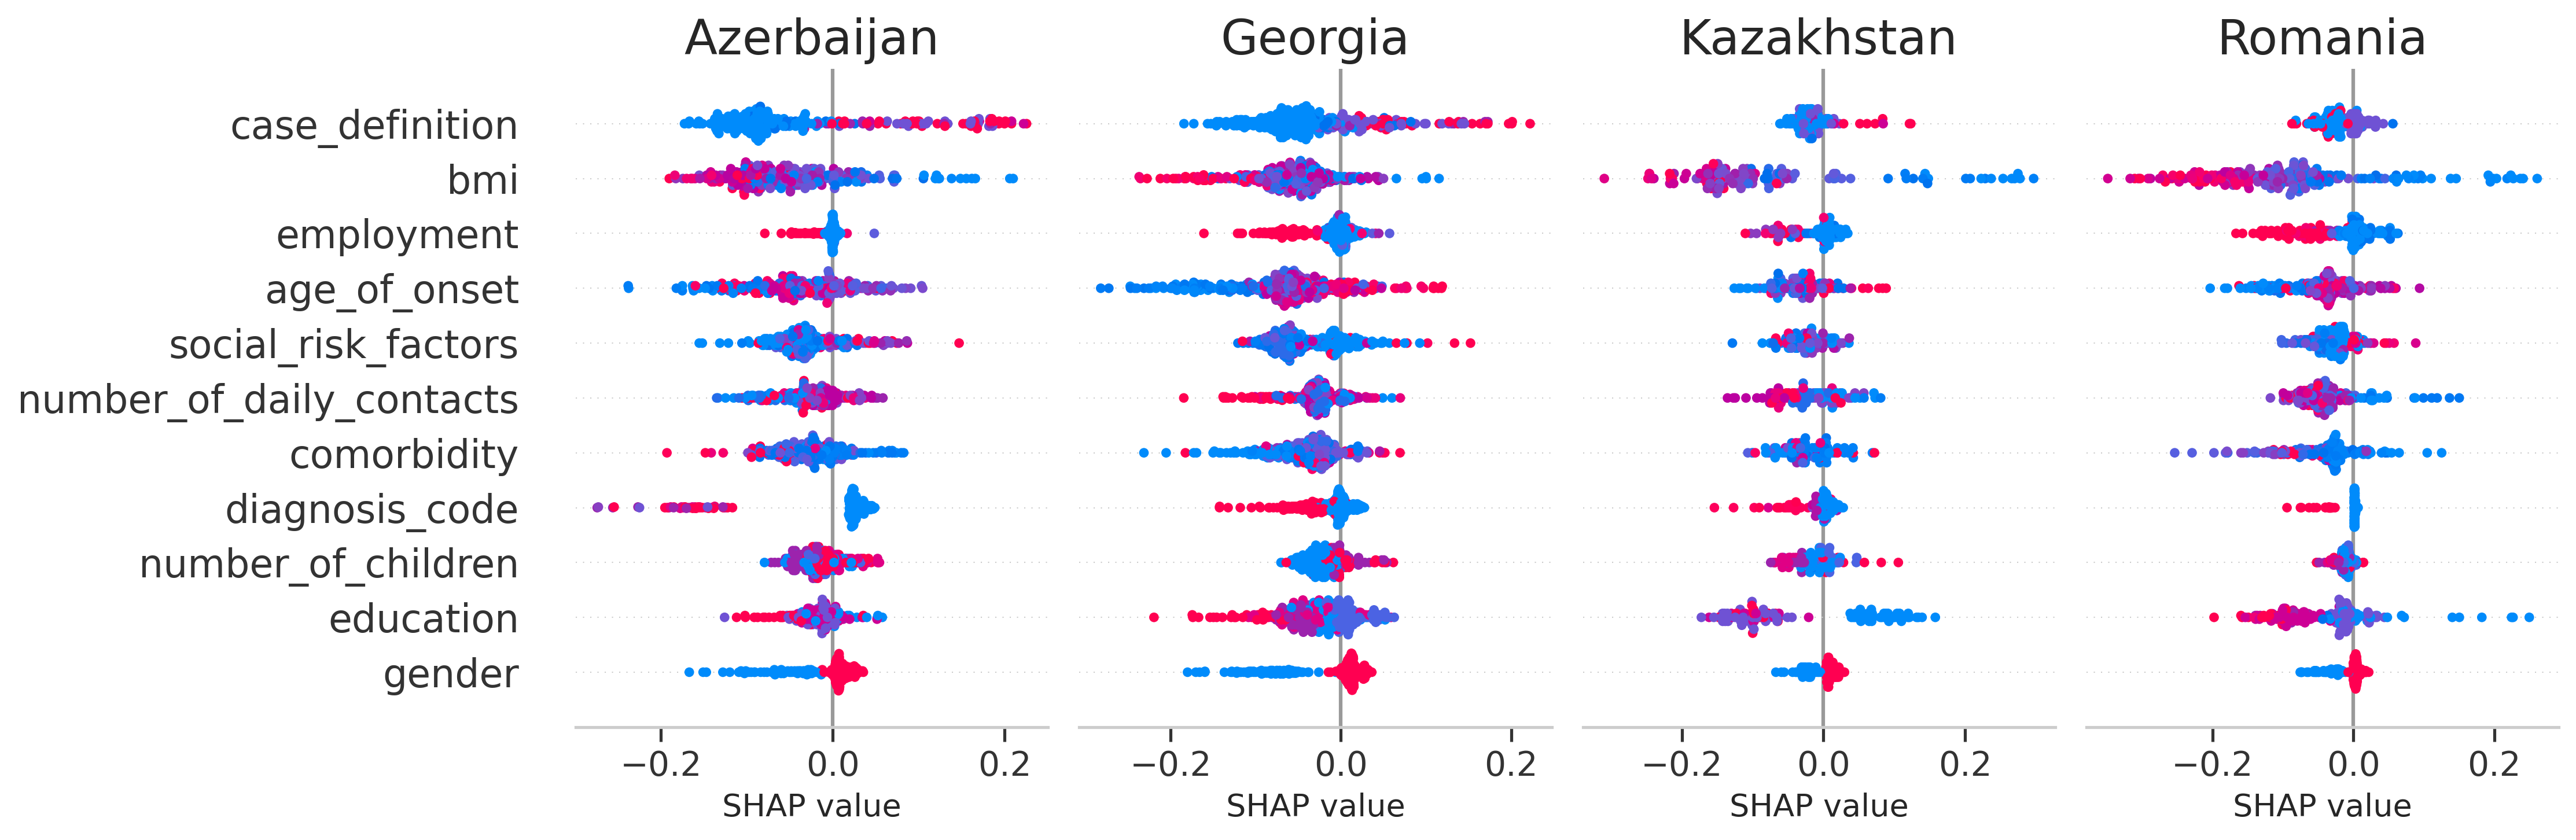

In [ ]:
# plot remaining countries
sns.set_style("whitegrid")

plt.figure(figsize=(15,5))
ax1=plt.subplot(1,4,1)
shap.plots.beeswarm(country_shap_obj[ix_others[0]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry), show=False)
ax1.tick_params(axis='y', which='major', labelsize=16)
ax1.tick_params(axis='x', which='major', labelsize=14)
ax1.grid(False)
ax1.set_xlabel("SHAP value")
plt.title(countriesOver100.categories[ix_others[0]],fontsize=20)

ax2=plt.subplot(1,4,2)
shap.plots.beeswarm(country_shap_obj[ix_others[1]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry),show=False)
ax2.tick_params(axis='x', which='major', labelsize=14)
plt.title(countriesOver100.categories[ix_others[1]],fontsize=20)
ax2.grid(False)
ax2.set_yticks([])
ax2.set_xlabel("SHAP value")

ax3=plt.subplot(1,4,3)
shap.plots.beeswarm(country_shap_obj[ix_others[2]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry), show=False)
ax3.tick_params(axis='x', which='major', labelsize=14)
plt.title(countriesOver100.categories[ix_others[2]],fontsize=20)
ax3.grid(False)
ax3.set_yticks([])
ax3.set_xlabel("SHAP value")

ax4=plt.subplot(1,4,4)
shap.plots.beeswarm(country_shap_obj[ix_others[3]][:,:,0], order=my_order, plot_size=None, color_bar=False, max_display=len(feats_noCountry), show=False)
ax4.tick_params(axis='x', which='major', labelsize=14)
plt.title(countriesOver100.categories[ix_others[3]],fontsize=20)
ax4.grid(False)
ax4.set_yticks([])
ax4.set_xlabel("SHAP value")


plt.tight_layout()
plt.savefig(fig_path+"/{}_SHAP_summary_bottomCountries.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

### Pathogen models

In [ ]:


print("Generating shap values...")
explainer = shap.TreeExplainer(pathogen_model)
shap_values_path = explainer.shap_values(X_val_pathogen)
explainer_object = explainer(X_val_pathogen)
shap_values_fail_path = shap_values_path[0]

# print("Generating DR shap values...")
# explainer_DR = shap.TreeExplainer(pathogen_model_dr)
# shap_values_DR = explainer.shap_values(X_val_pathogen_dr)
# explainer_object_DR = explainer_DR(X_val_pathogen_dr)
# shap_values_fail_DR = shap_values_DR[0]



Generating shap values...


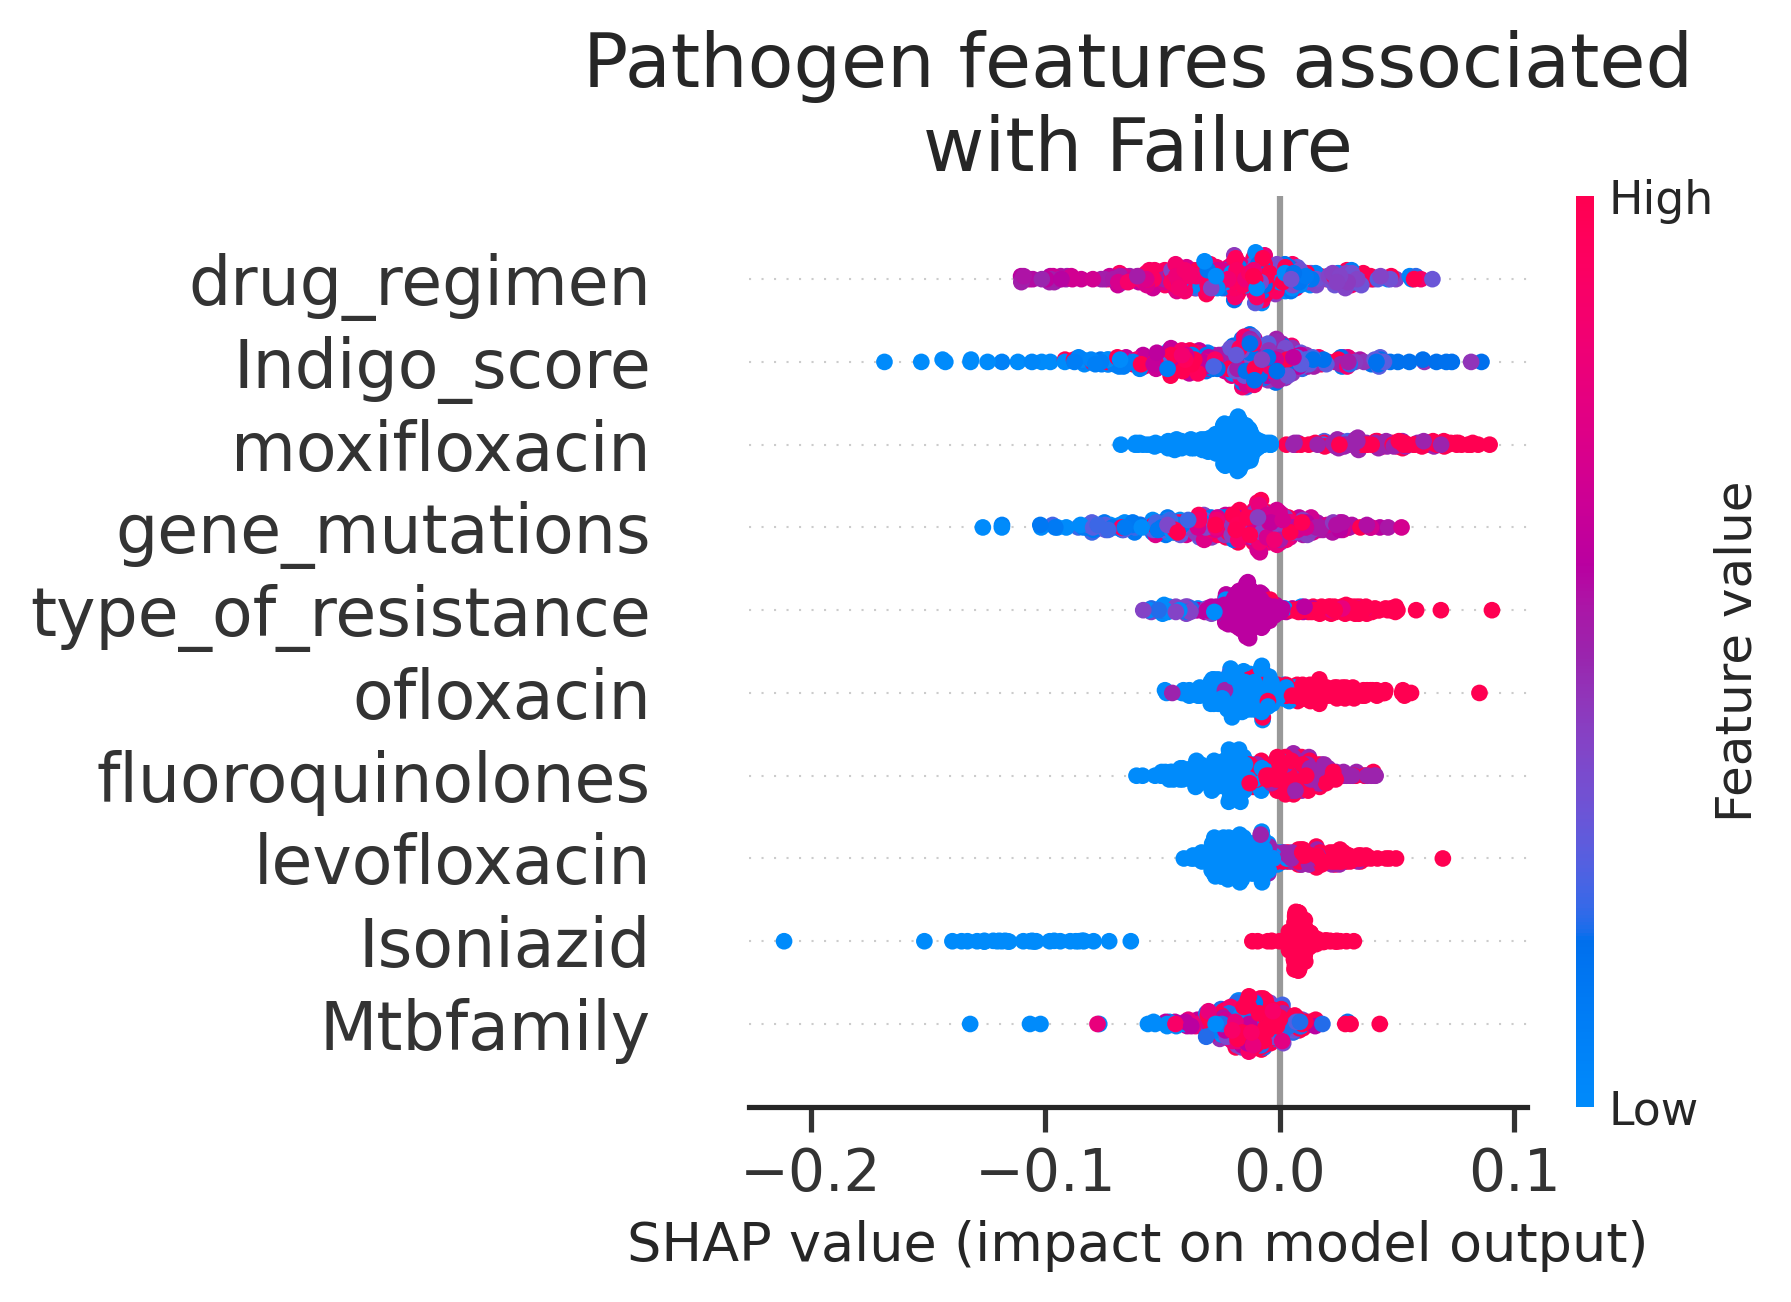

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.rcParams["font.family"] = "DejaVu Sans"
sns.set(style='white')

condition="AllPatients_Pathogen"
plt.figure(figsize=(4,5))
shap.summary_plot(shap_values_fail_path, X_val_pathogen, color_bar=True, show=False, max_display=10, plot_size=[6,4.5])
plt.title("Pathogen features associated\nwith Failure", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
# plt.xlabel(fontsize=16)
plt.tight_layout()
plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

# # DR
# condition="DR_Pathogen"
# plt.figure(figsize=(2,5))
# shap.summary_plot(shap_values_fail_DR, X_val_pathogen_dr, show=False, max_display=10, plot_size=[6,4.5])
# plt.title("Pathogen features associated\nwith Failure (drug-resistant)", fontsize=18)
# plt.yticks(fontsize=16)
# plt.xticks(np.arange(-0.2, 0.1, 0.1), fontsize=14)
# plt.tight_layout()
# plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
#                 dpi=300)
# plt.show()

### CT models

In [ ]:


print("Generating shap values...")
explainer = shap.TreeExplainer(ct_model)
shap_values_ct = explainer.shap_values(X_val_ct)
explainer_object = explainer(X_val_ct)
shap_values_fail_CT = shap_values_ct[0]

# print("Generating DR shap values...")
# explainer_DR = shap.TreeExplainer(ct_model_dr)
# shap_values_DR = explainer.shap_values(X_val_ct_dr)
# explainer_object_DR = explainer_DR(X_val_ct_dr)
# shap_values_fail_DR = shap_values_DR[0]




Generating shap values...


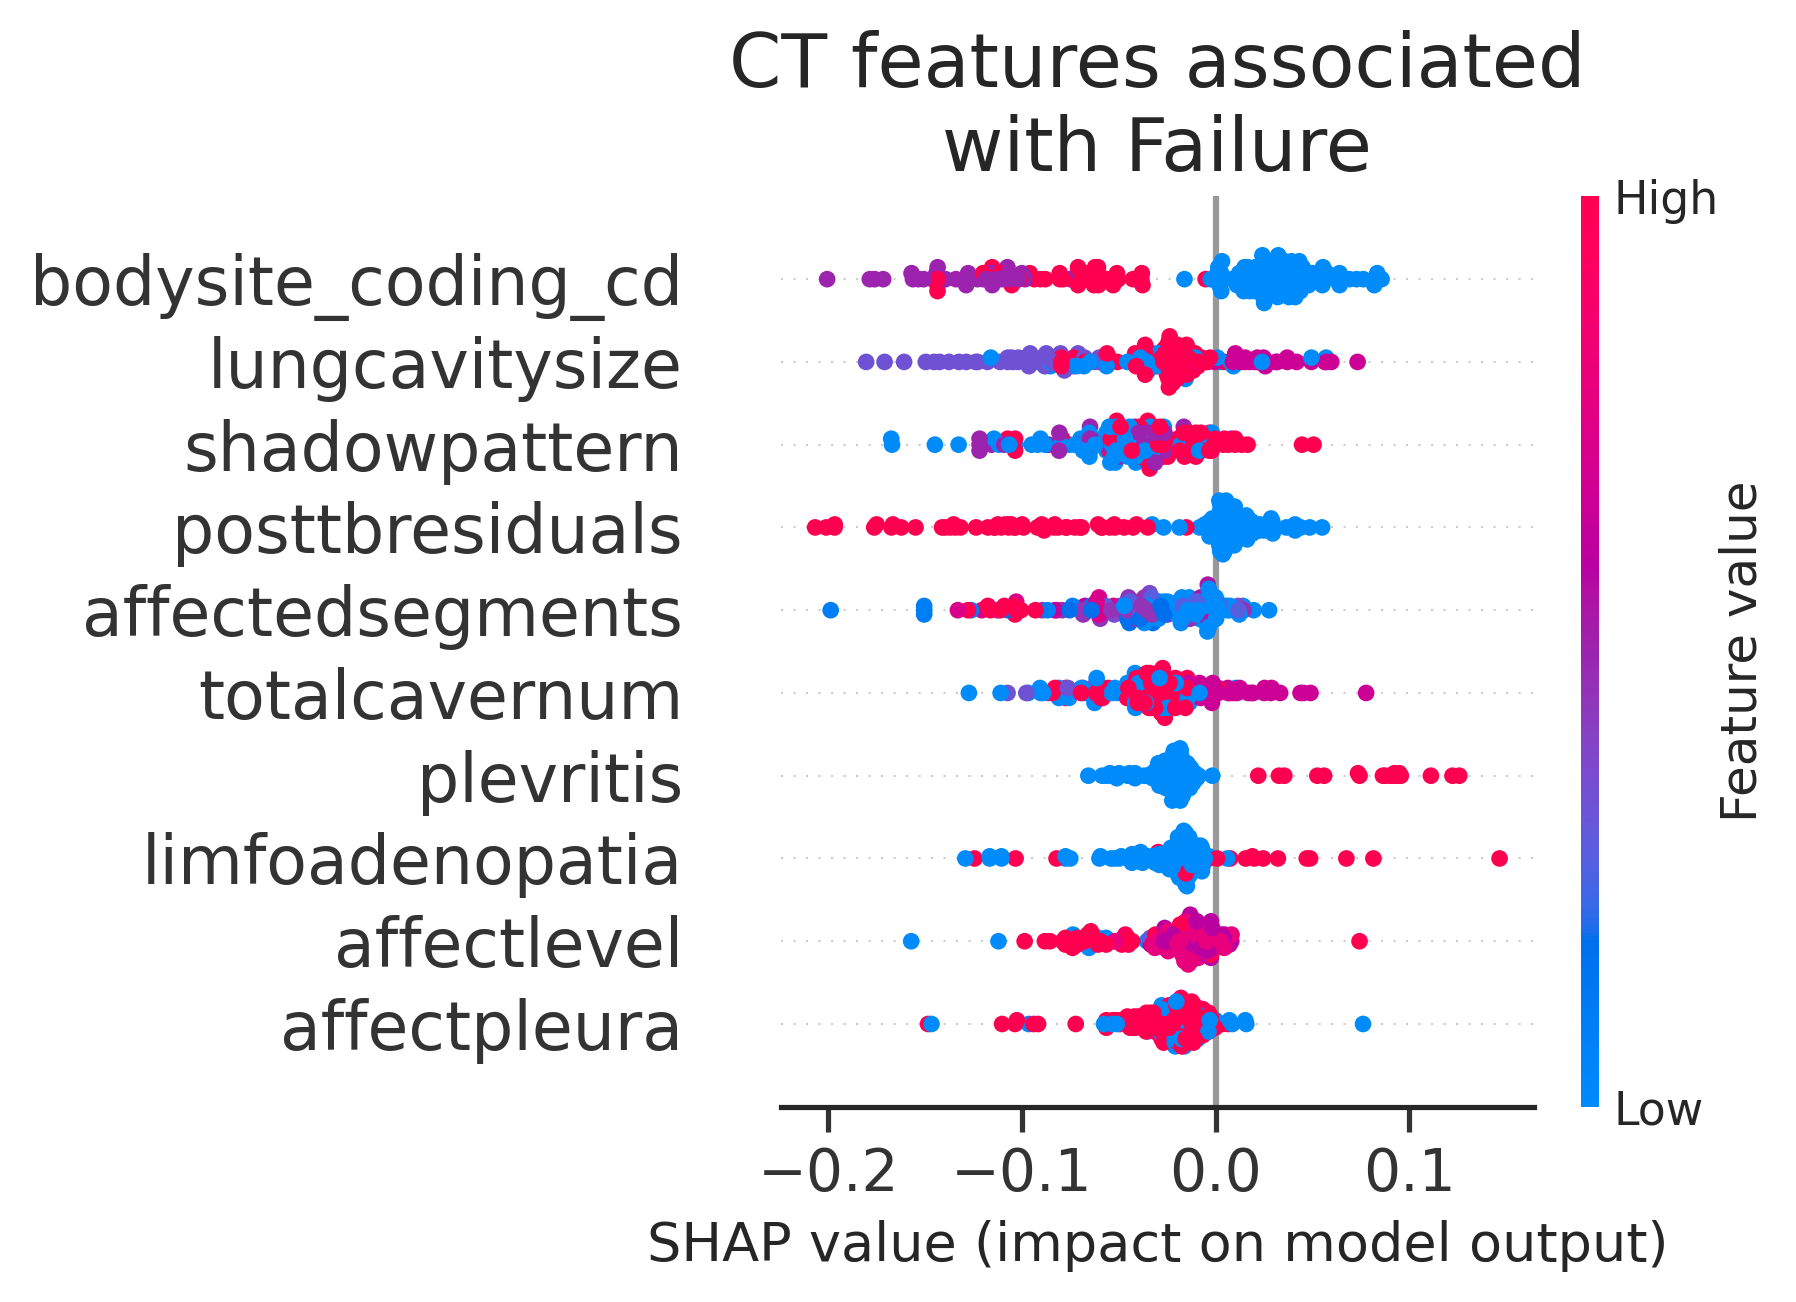

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.rcParams["font.family"] = "DejaVu Sans"
sns.set(style='white')

condition="AllPatients_CT"
plt.figure(figsize=(4,5))
shap.summary_plot(shap_values_fail_CT, X_val_ct, color_bar=True, show=False, max_display=10, plot_size=[6,4.5])
plt.title("CT features associated\nwith Failure", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
# plt.xlabel(fontsize=16)
plt.tight_layout()
plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

# # DR
# condition="DR_CT"
# plt.figure(figsize=(2,5))
# shap.summary_plot(shap_values_fail_DR, X_val_ct_dr, show=False, max_display=10, plot_size=[6,4.5])
# plt.title("CT features associated\nwith Failure (drug-resistant)", fontsize=18)
# plt.yticks(fontsize=16)
# plt.xticks(np.arange(-0.2, 0.1, 0.1), fontsize=14)
# plt.tight_layout()
# plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
#                 dpi=300)
# plt.show()

### Xray models

In [ ]:


print("Generating shap values...")
explainer = shap.TreeExplainer(xray_model)
shap_values_xray = explainer.shap_values(X_val_xray)
explainer_object = explainer(X_val_xray)
shap_values_fail_xray = shap_values_xray[0]

# print("Generating DR shap values...")
# explainer_DR = shap.TreeExplainer(xray_model_dr)
# shap_values_DR = explainer.shap_values(X_val_xray_dr)
# explainer_object_DR = explainer_DR(X_val_xray_dr)
# shap_values_fail_DR = shap_values_DR[0]



Generating shap values...


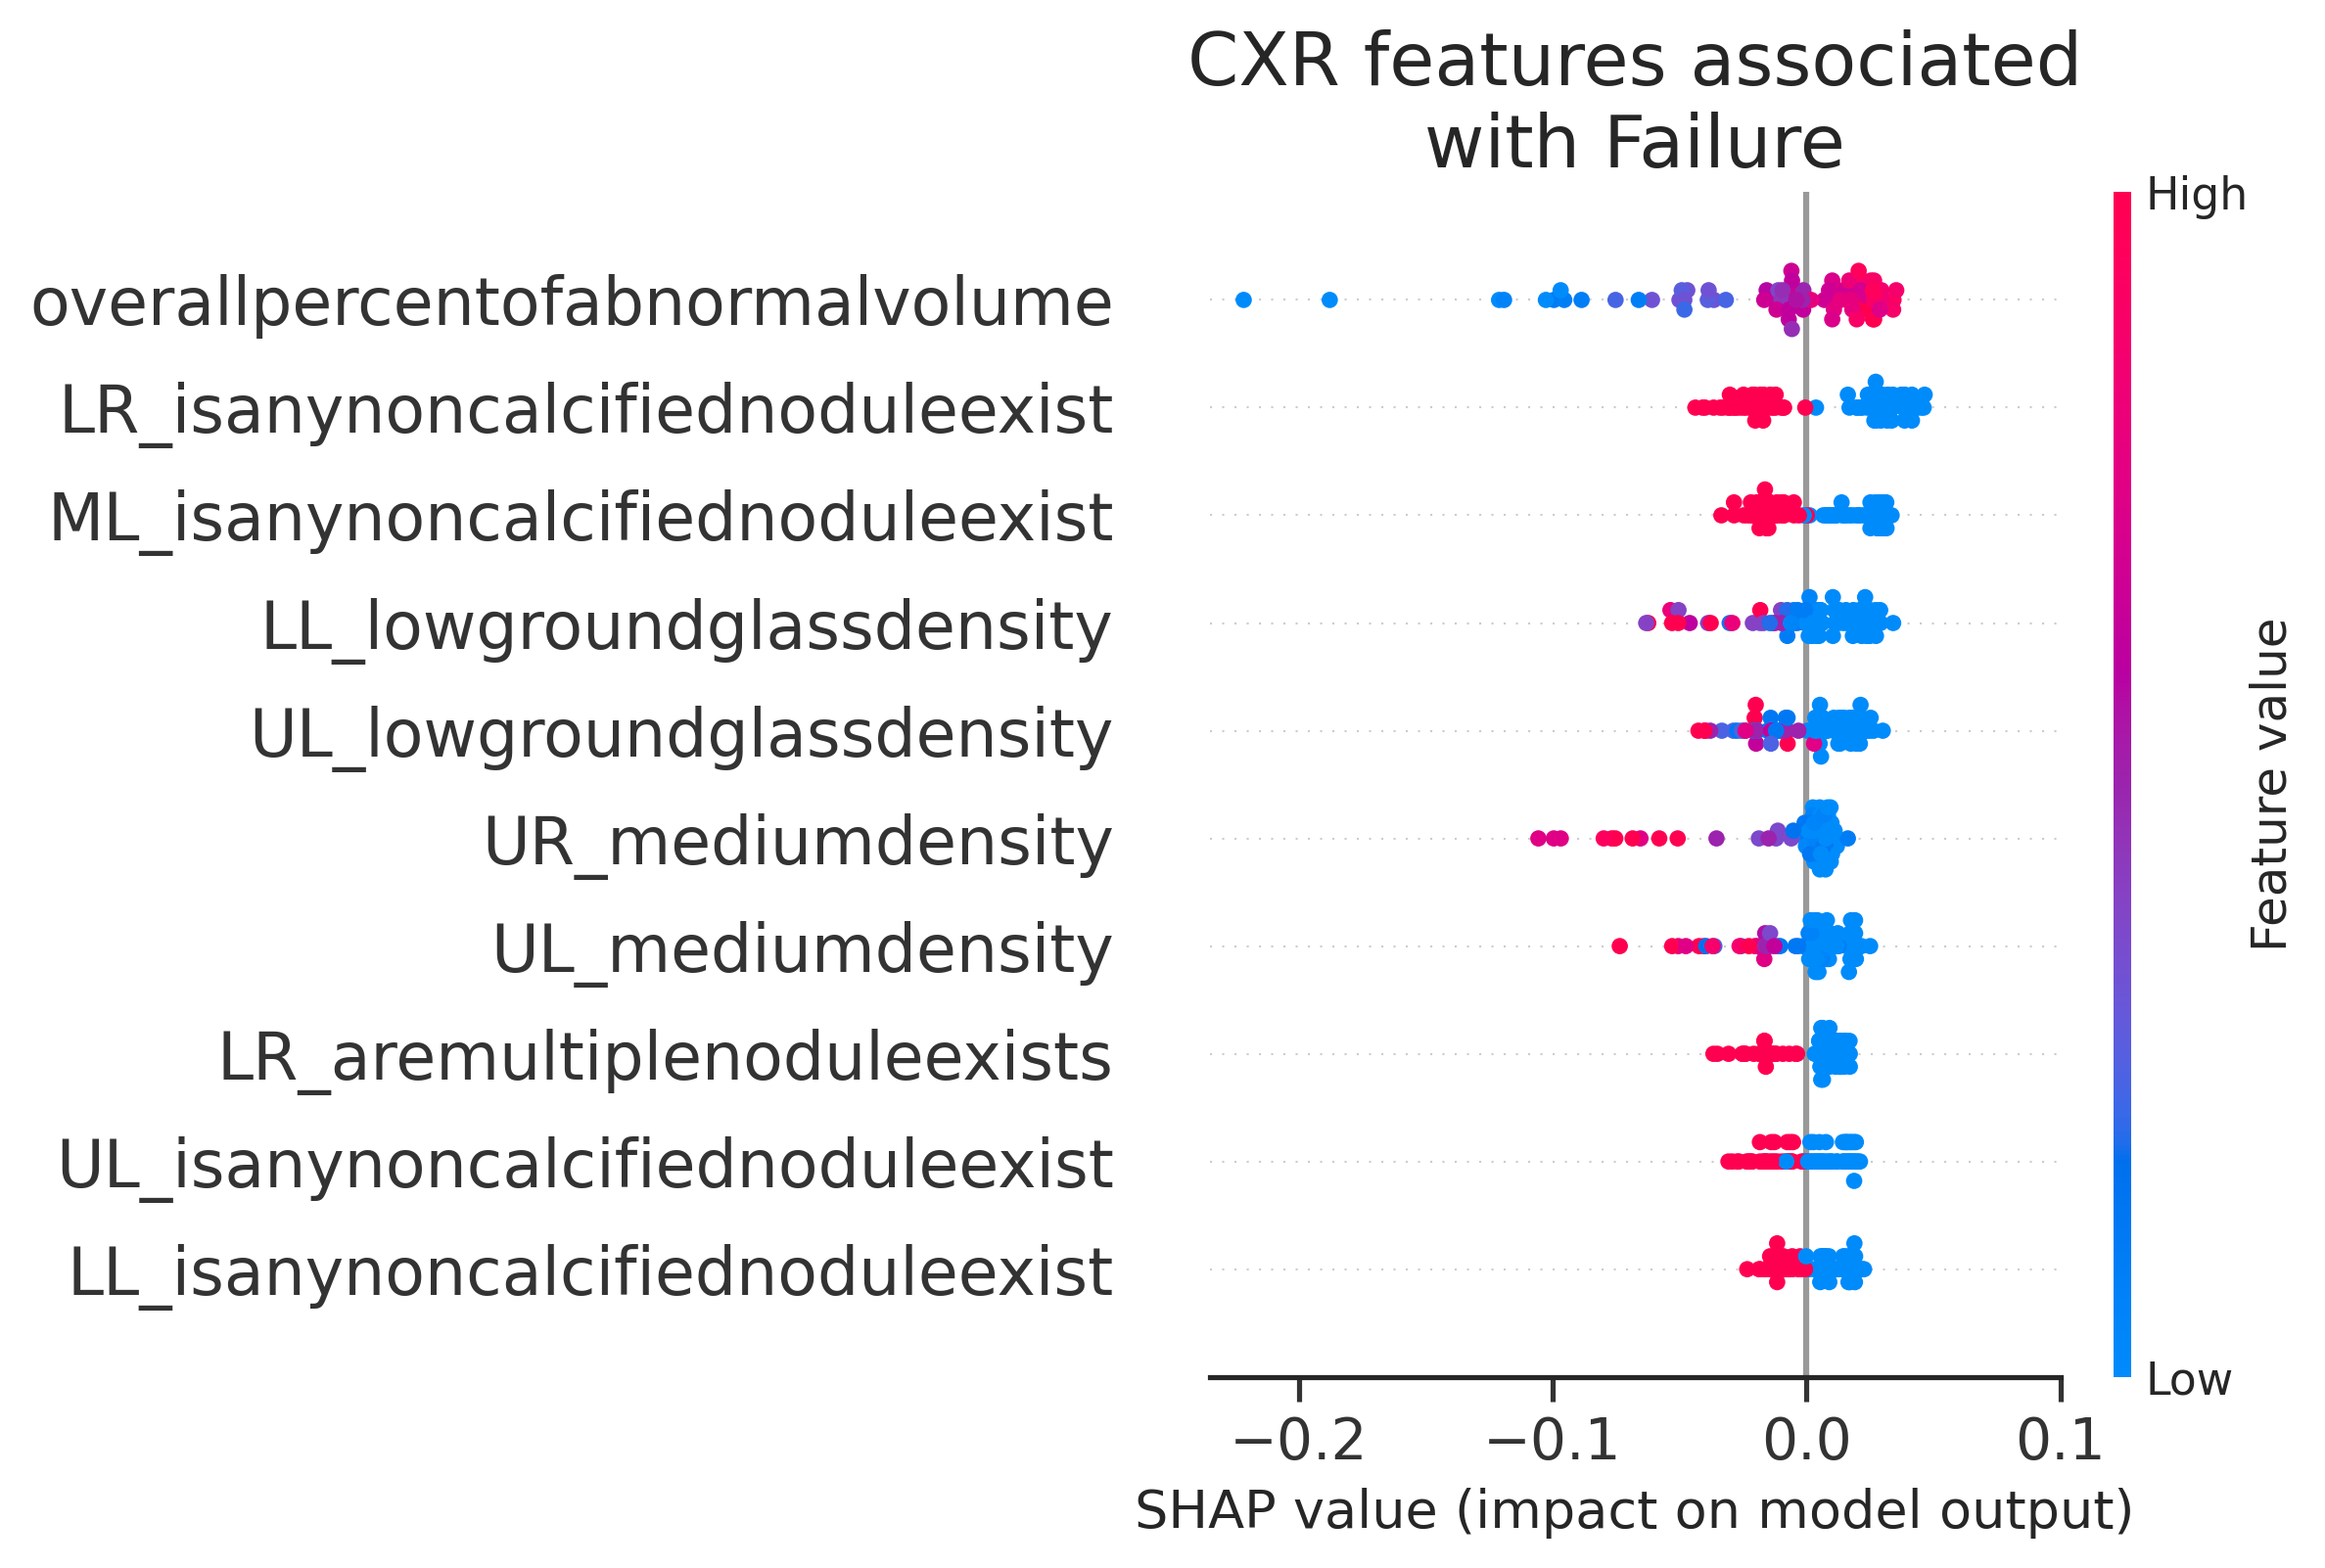

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.rcParams["font.family"] = "DejaVu Sans"
sns.set(style='white')

condition="AllPatients_Xray"
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values_fail_xray, X_val_xray, color_bar=True, show=False, max_display=10) #plot_size=[6,4.5]
plt.title("CXR features associated\nwith Failure", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(np.arange(-0.2, 0.2, 0.1), fontsize=14)
# plt.xlabel(fontsize=16)
plt.tight_layout()
plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

# # DR
# condition="DR_Xray"
# plt.figure(figsize=(5,5))
# shap.summary_plot(shap_values_fail_DR, X_val_xray_dr, show=False, max_display=10)  #plot_size=[6,4.5]
# plt.title("CXR features associated\nwith Failure (drug-resistant)", fontsize=18)
# plt.yticks(fontsize=16)
# plt.xticks(np.arange(-0.2, 0.1, 0.1), fontsize=14)
# plt.tight_layout()
# plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
#                 dpi=300)
# plt.show()

### Integrated models - highN

In [ ]:

print("Generating shap values...")
print(X_val_highN.shape)
explainer = shap.TreeExplainer(integrated_model)
shap_values_highN = explainer.shap_values(X_val_highN)
explainer_object = explainer(X_val_highN)
shap_values_fail_highN = shap_values_highN[0]

# print("Generating DR shap values...")
# explainer_DR = shap.TreeExplainer(integrated_dr_model)
# shap_values_DR = explainer.shap_values(X_val_int_dr)
# explainer_object_DR = explainer_DR(X_val_int_dr)
# shap_values_fail_DR = shap_values_DR[0]



Generating shap values...
(429, 163)


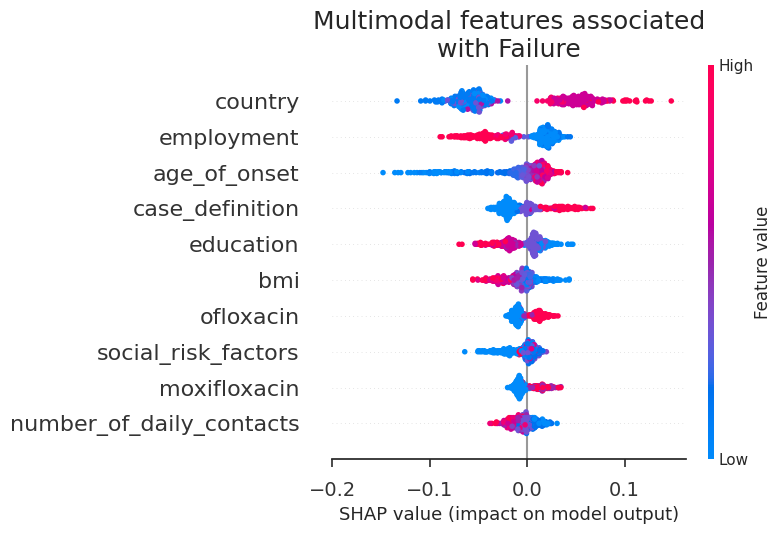

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.rcParams["font.family"] = "DejaVu Sans"
sns.set(style='white')

condition="integrated_highN"
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values_fail_highN, X_val_highN, color_bar=True, show=False, max_display=10) #plot_size=[6,4.5]
plt.title("Multimodal features associated\nwith Failure", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(np.arange(-0.2, 0.2, 0.1), fontsize=14)
# plt.xlabel(fontsize=16)
plt.tight_layout()
plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

# # DR
# condition="DR_integrated"
# plt.figure(figsize=(5,5))
# shap.summary_plot(shap_values_fail_DR, X_val_int_dr, show=False, max_display=10)  #plot_size=[6,4.5]
# plt.title("Multimodal features associated\nwith Failure (drug-resistant)", fontsize=18)
# plt.yticks(fontsize=16)
# plt.xticks(np.arange(-0.2, 0.1, 0.1), fontsize=14)
# plt.tight_layout()
# plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
#                 dpi=300)
# plt.show()

### Integrated models - lowN

In [ ]:

print("Generating shap values...")
print(X_train_lowN.shape)
explainer = shap.TreeExplainer(integrated_lowN_model)
shap_values = explainer.shap_values(X_train_lowN)
explainer_object = explainer(X_train_lowN)
shap_values_fail = shap_values[0]

# print("Generating DR shap values...")
# explainer_DR = shap.TreeExplainer(integrated_dr_model)
# shap_values_DR = explainer.shap_values(X_val_int_dr)
# explainer_object_DR = explainer_DR(X_val_int_dr)
# shap_values_fail_DR = shap_values_DR[0]



Generating shap values...
(164, 163)


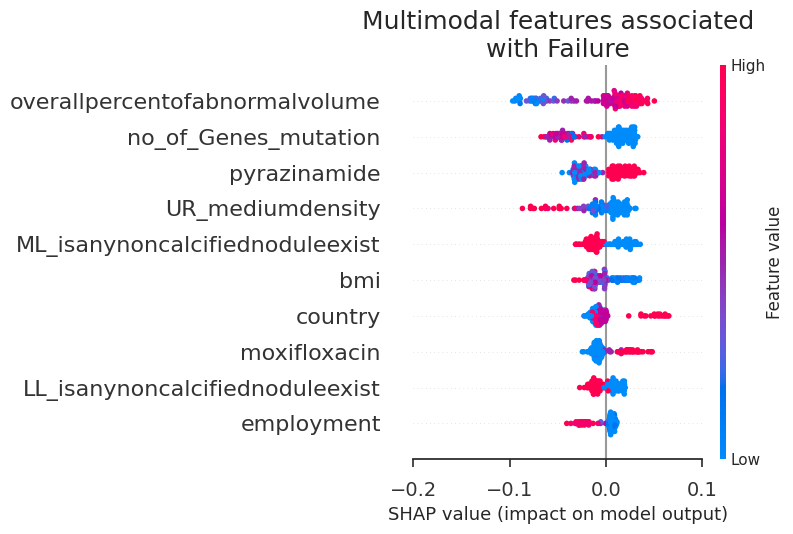

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.rcParams["font.family"] = "DejaVu Sans"
sns.set(style='white')

condition="integrated_lowN"
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values_fail, X_train_lowN, color_bar=True, show=False, max_display=10) #plot_size=[6,4.5]
plt.title("Multimodal features associated\nwith Failure", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(np.arange(-0.2, 0.2, 0.1), fontsize=14)
# plt.xlabel(fontsize=16)
plt.tight_layout()
plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
                dpi=300)
plt.show()

# # DR
# condition="DR_integrated"
# plt.figure(figsize=(5,5))
# shap.summary_plot(shap_values_fail_DR, X_val_int_dr, show=False, max_display=10)  #plot_size=[6,4.5]
# plt.title("Multimodal features associated\nwith Failure (drug-resistant)", fontsize=18)
# plt.yticks(fontsize=16)
# plt.xticks(np.arange(-0.2, 0.1, 0.1), fontsize=14)
# plt.tight_layout()
# plt.savefig(fig_path+"/SHAP_summary_{}.pdf".format(condition),format="pdf",
#                 dpi=300)
# plt.show()

### Save workspace

In [ ]:
dill.dump_session('./final_TB_workspace_Sept2023.pkl')


### Get top features

In [ ]:
def top_shap_feats(shap_vals, features, n=10):
  vals = np.abs(shap_vals).mean(0)

  feature_importance = pd.DataFrame(list(zip(features, vals)),
                                  columns=['feature','avg_shap_val'])
  feature_importance.sort_values(by=['avg_shap_val'],
                                ascending=False, inplace=True)
  feature_importance = feature_importance.nlargest(n, 'avg_shap_val')
  return feature_importance

In [ ]:
top_social_feats = top_shap_feats(shap_values_fail_social, features_social_final)
top_pathogen_feats = top_shap_feats(shap_values_fail_path, features_pathogen_final)
top_xray_feats = top_shap_feats(shap_values_fail_xray, features_xray_final)
top_ct_feats = top_shap_feats(shap_values_fail_CT, features_ct_final)

top_multi_feats = top_shap_feats(shap_values_fail_highN, all_feats_final, n=30)


In [ ]:
# print(len(intersection(top_social_feats.feature, top_all_feats.feature)))
# print(len(intersection(top_pathogen_feats.feature, top_all_feats.feature)))
# print(len(intersection(top_xray_feats.feature, top_all_feats.feature)))
# print(len(intersection(top_ct_feats.feature, top_all_feats.feature)))

print(len(intersection(features_social_final, top_multi_feats.feature)))
print((intersection(features_social_final, top_multi_feats.feature)))

print(len(intersection(features_pathogen_final, top_multi_feats.feature)))
print((intersection(features_pathogen_final, top_multi_feats.feature)))

print(len(intersection(features_xray_final, top_multi_feats.feature)))
print((intersection(features_xray_final, top_multi_feats.feature)))

print(len(intersection(features_ct_final, top_multi_feats.feature)))
print((intersection(features_ct_final, top_multi_feats.feature)))


11
['age_of_onset', 'gender', 'country', 'education', 'employment', 'number_of_children', 'number_of_daily_contacts', 'case_definition', 'bmi', 'social_risk_factors', 'comorbidity']
12
['type_of_resistance', 'Colonies', 'fluoroquinolones', 'Isoniazid', 'levofloxacin', 'moxifloxacin', 'ofloxacin', 'Rifampicin', 'gene_mutations', 'no_of_Genes_mutation', 'Indigo_score', 'drug_regimen']
7
['LR_isanynoncalcifiednoduleexist', 'ML_smallnodules', 'ML_isanynoncalcifiednoduleexist', 'MR_isanynoncalcifiednoduleexist', 'UR_largecavities', 'UR_lowgroundglassdensity', 'overallpercentofabnormalvolume']
0
[]


In [ ]:
df_social_top = df_social_uniq[['patient_id']+intersection(features_social_final, top_multi_feats.feature)]
df_pathogen_top = df_pathogen_uniq[['patient_id']+intersection(features_pathogen_final, top_multi_feats.feature)]
df_xray_top = df_xray_uniq[['patient_id']+intersection(features_xray_final, top_multi_feats.feature)]

print(df_social_top.shape)
print(df_pathogen_top.shape)
print(df_xray_top.shape)

df_combined_top = pd.merge(df_social_top, df_pathogen_top, on='patient_id', how='inner')
print(df_combined_top.shape)
df_combined_top = pd.merge(df_combined_top, df_xray_top, on='patient_id', how='inner')
print(df_combined_top.shape)

(4164, 12)
(4058, 13)
(406, 8)
(4307, 24)
(408, 31)


In [ ]:
df_combined_top2 = df_combined_top.copy()
to_obj_cols = ['LR_isanynoncalcifiednoduleexist','ML_isanynoncalcifiednoduleexist','MR_isanynoncalcifiednoduleexist']
df_combined_top2[to_obj_cols] = df_combined_top2[to_obj_cols].astype(object)
to_float_cols = df_combined_top2.select_dtypes(include=['int']).columns
print(to_float_cols)
df_combined_top2[to_float_cols] = df_combined_top2[to_float_cols].astype(float)

dv_pvals_all = get_associations(df_combined_top2, top_multi_feats.feature)

# # save to file
dv_pvals_all.index = top_multi_feats.feature
dv_pvals_all.to_csv("feature_association_pvals_sept2023.csv")

Index(['no_of_Genes_mutation', 'ML_smallnodules', 'UR_largecavities',
       'UR_lowgroundglassdensity', 'overallpercentofabnormalvolume'],
      dtype='object')
country
employment
age_of_onset
case_definition
education
bmi
ofloxacin
social_risk_factors
moxifloxacin
number_of_daily_contacts
levofloxacin
number_of_children
overallpercentofabnormalvolume
drug_regimen
fluoroquinolones
Not enough values for test!
Indigo_score
comorbidity
type_of_resistance
gene_mutations
Rifampicin
gender
Isoniazid
no_of_Genes_mutation
ML_isanynoncalcifiednoduleexist
ML_smallnodules
MR_isanynoncalcifiednoduleexist
UR_largecavities
LR_isanynoncalcifiednoduleexist
Colonies
UR_lowgroundglassdensity


In [ ]:
K='patient_id'
top_social_cols = list(df_social_top.columns)
top_pathogen_cols = list(df_pathogen_top.columns)
top_xray_cols = list(df_xray_top.columns)


while(K in top_social_cols):
    top_social_cols.remove(K)
while(K in top_pathogen_cols):
    top_pathogen_cols.remove(K)
while(K in top_xray_cols):
    top_xray_cols.remove(K)

my_cols = list()
my_cols.extend(top_social_cols)
my_cols.extend(top_pathogen_cols)
my_cols.extend(top_xray_cols)


In [ ]:
len(my_cols)
dv_pvals_ordered = dv_pvals_all.loc[my_cols, my_cols]
dv_pvals_ordered.head()

age_of_onset        gender       country     education  \
feature                                                                
age_of_onset  0.000000e+00  3.306449e-07  1.780045e-01  7.272799e-01   
gender        3.306449e-07  0.000000e+00  1.704841e-02  1.649395e-01   
country       1.780045e-01  1.704841e-02  0.000000e+00  1.465713e-41   
education     7.272799e-01  1.649395e-01  1.465713e-41  0.000000e+00   
employment    1.906375e-12  3.893043e-01  5.947859e-08  3.662977e-06   

                employment  number_of_children  number_of_daily_contacts  \
feature                                                                    
age_of_onset  1.906375e-12            0.126898                  0.230376   
gender        3.893043e-01            0.231149                  0.056413   
country       5.947859e-08            0.059196                  0.001293   
education     3.662977e-06            0.784290                  0.049694   
employment    0.000000e+00            0.621725                  0.327404   

              case_definition       bmi  social_risk_factors  ...  \
feature                                                       ...   
age_of_onset     6.063091e-01  0.181224         7.080959e-01  ...   
gender           1.509796e-02  0.632293         7.274713e-01  ...   
country          1.458296e-08  0.001277         7.223664e-23  ...   
education        9.188791e-13  0.021044         1.038560e-01  ...   
employment       1.162711e-14  0.097488         3.919034e-06  ...   

              no_of_Genes_mutation  Indigo_score  drug_regimen  \
feature                                                          
age_of_onset          7.104736e-02  5.611893e-02  4.743596e-01   
gender                1.023742e-02  1.525339e-02  1.008490e-02   
country               1.675353e-30  2.154101e-17  4.835439e-51   
education             2.491246e-04  3.038152e-01  7.523481e-10   
employment            1.799527e-02  5.281453e-01  6.133623e-01   

              LR_isanynoncalcifiednoduleexist  ML_smallnodules  \
feature                                                          
age_of_onset                     9.956319e-01     2.652200e-01   
gender                           1.000000e+00     1.229951e-02   
country                          8.429826e-27     2.191004e-21   
education                        3.490296e-04     7.451466e-05   
employment                       3.017751e-01     1.442048e-01   

              ML_isanynoncalcifiednoduleexist  \
feature                                         
age_of_onset                     2.488447e-01   
gender                           9.688080e-02   
country                          1.552564e-23   
education                        3.944393e-04   
employment                       2.147223e-02   

              MR_isanynoncalcifiednoduleexist  UR_largecavities  \
feature                                                           
age_of_onset                     2.857656e-01          0.048356   
gender                           3.260727e-01          0.287133   
country                          2.027381e-24          0.001393   
education                        5.823957e-03          0.132102   
employment                       1.558622e-01          0.036268   

              UR_lowgroundglassdensity  overallpercentofabnormalvolume  
feature                                                                 
age_of_onset              4.654934e-01                    9.729864e-01  
gender                    5.430199e-02                    1.237715e-01  
country                   9.315247e-19                    6.372010e-26  
education                 4.300765e-07                    9.665023e-02  
employment                6.498157e-01                    4.305694e-03  

[5 rows x 30 columns]

divide by zero encountered in log10


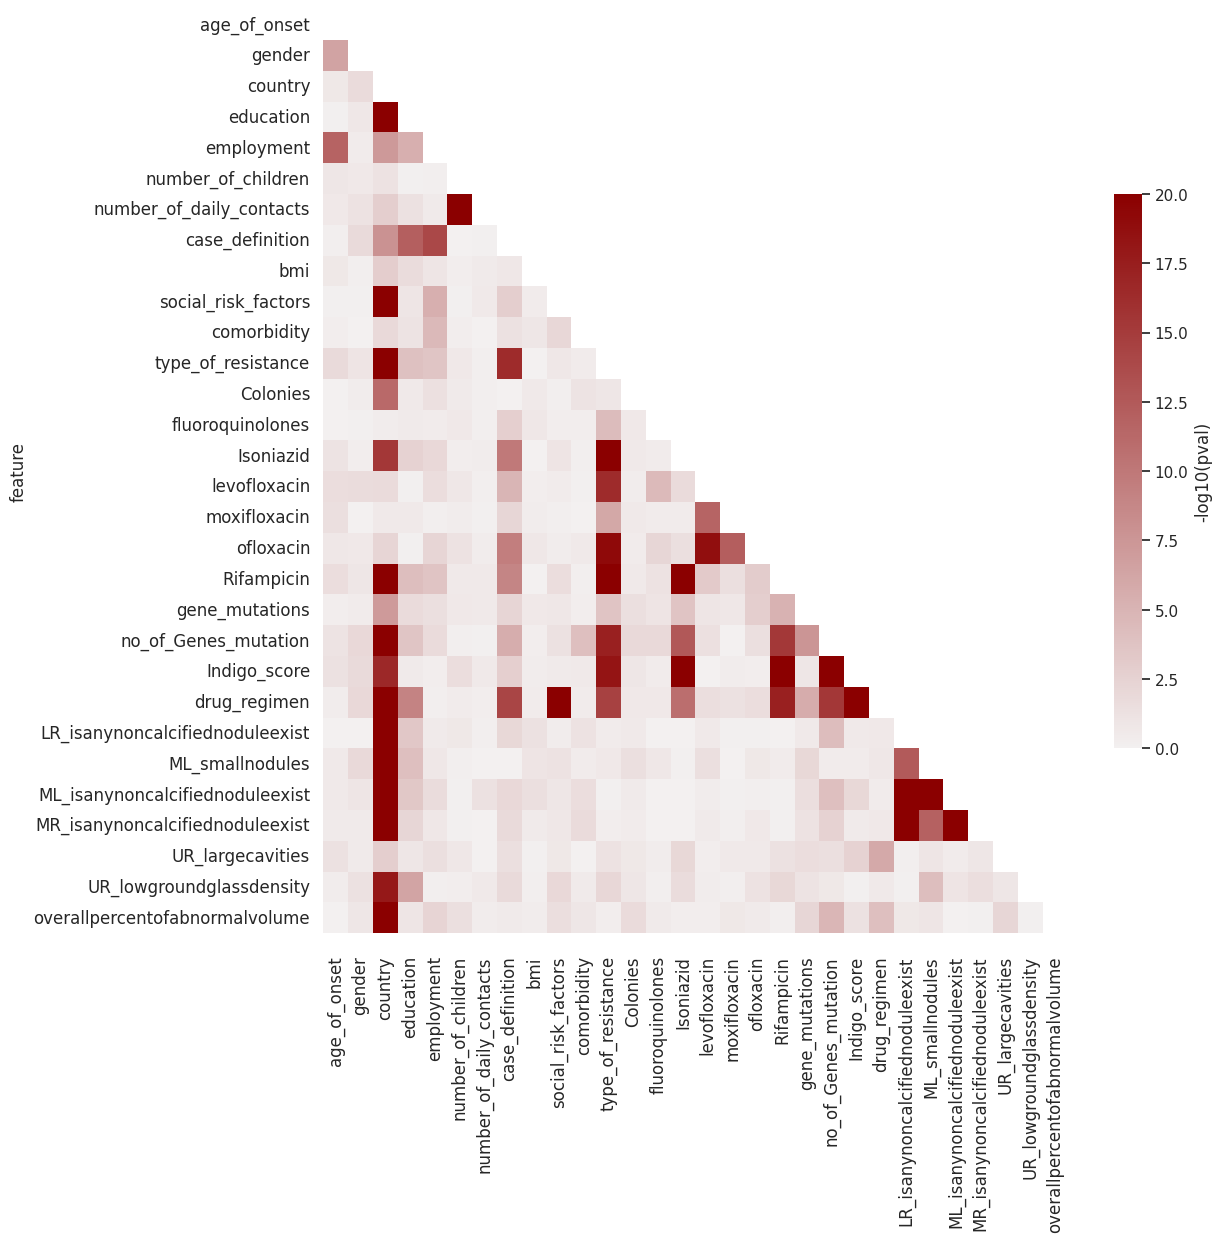

In [ ]:
### Generate heatmaps of the resulting p-values
# 1.   No p-value correction (*showing -log10 p-values)

df_pvals_log = np.log10(dv_pvals_ordered)*-1

tick_labels = df_pvals_log.index

df_pvals_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
# df_pvals_log.replace([np.inf, -np.inf], 0, inplace=True)


# # Create a mask
mask = np.triu(np.ones_like(df_pvals_log, dtype=bool))

# Create a custom divergin palette
sns.set(style='white')
cmap = sns.light_palette("darkred", as_cmap=True, reverse=False)

# plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(figsize=(12,12)) # (12,12)
ax=sns.heatmap(df_pvals_log, mask=mask, cmap=cmap, vmin=0, vmax=20, cbar_kws={'shrink': 0.6, 'label': '-log10(pval)'})
# ax.set_xticks(features)
ax.set_xticklabels(tick_labels, rotation = 90, size=12)
ax.set_yticklabels(tick_labels, rotation = 0,  size=12)
plt.savefig(fig_path+"/association_heatmap.pdf",bbox_inches ="tight", dpi=600, format="pdf")
plt.show()


In [ ]:
# np.max(df_pvals_log, axis=None)

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


country                            50.315564
employment                         13.934528
age_of_onset                       11.719792
case_definition                    16.405456
education                          40.833951
bmi                                 2.893775
ofloxacin                          19.186429
social_risk_factors                22.141242
moxifloxacin                       12.187030
number_of_daily_contacts           25.157651
levofloxacin                       18.796231
number_of_children                 25.157651
overallpercentofabnormalvolume     25.195724
drug_regimen                       50.315564
fluoroquinolones                    4.481646
Indigo_score                       26.560696
comorbidity                         4.576950
type_of_resistance                 68.788075
gene_mutations                      7.640474
Rifampicin                         68.788075
gender                              6.480638
Isoniazid                          67.838107
no_of_Gene

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


<Figure size 1200x1200 with 0 Axes>

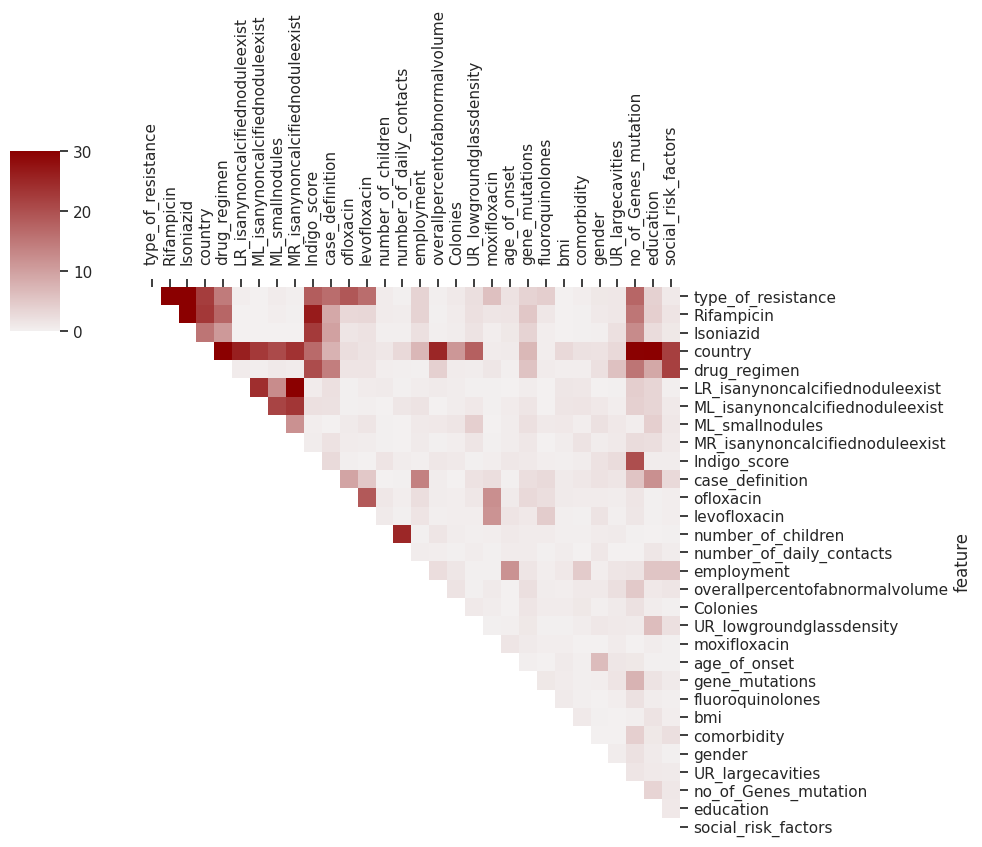

In [ ]:
plt.figure(figsize=(12,12)) # (12,12)
g=sns.clustermap(df_pvals_log, cmap=cmap, vmin=0, vmax=30)
mask = np.tril(np.ones_like(df_pvals_log))
values = g.ax_heatmap.collections[0].get_array().reshape(df_pvals_log.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.xaxis.tick_top()
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)  # ytick rotate
# ax.set_xticks(features)
# ax.set_xticklabels(tick_labels, rotation = 90, size=12)
# ax.set_yticklabels(tick_labels, rotation = 0,  size=12)
plt.savefig(fig_path+"/association_clustermap.pdf",bbox_inches ="tight", dpi=600, format="pdf")
plt.show()

